# 101 阿尔法公式

基于 [101 Formulaic Alphas](https://arxiv.org/pdf/1601.00991.pdf)，Zura Kakushadze，arxiv，2015

## 导入和设置

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

import numpy as np
import pandas as pd
from sklearn.feature_selection import mutual_info_regression
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
from talib import WMA

In [3]:
idx= pd.IndexSlice
sns.set_style('whitegrid')

>“阿尔法是数学表达式、计算机源代码和配置参数的组合
> 可以结合历史数据来预测各种未来的走势
> 金融工具”

[寻找阿尔法：构建交易策略的定量方法](https://books.google.com/books?hl=en&lr=&id=ntuuDwAAQBAJ&oi=fnd&pg=PR11&dq=Finding+Alphas:+A+Quantitative+Approach+to+建筑+交易+策略&ots=nQrqbJlQu1&sig=FWfLI0_AIJWiNJ3D6tE0twHjj5I#v=onepage&q=Finding%20Alphas%3A%20A%20Quantitative%20Approach%20to%20Building%20Trading%20Strategies&f=false), Igor Tulchinsky , 2019

## 函数

下面定义 101 个公式 alpha 的表达式包含用于时间序列和横截面计算的函数。

### 横截面

| 函数| 定义 |
|:---|:---|
|rank(x) | 横截面排名|
|scale(x, a) | 重新缩放 x 使得 sum(abs(x)) = a（默认值为 a = 1）|
|indneutralize(x, g) | x 在 g 组（子行业、行业等）内受到横截面贬低 |


In [4]:
def rank(df):
    """Return the cross-sectional percentile rank

     Args:
         :param df: tickers in columns, sorted dates in rows.

     Returns:
         pd.DataFrame: the ranked values
     """
    return df.rank(axis=1, pct=True)

In [5]:
def scale(df):
    """
    Scaling time serie.
    :param df: a pandas DataFrame.
    :param k: scaling factor.
    :return: a pandas DataFrame rescaled df such that sum(abs(df)) = k
    """
    return df.div(df.abs().sum(axis=1), axis=0)

### 运算

- abs(x)、log(x)、sign(x)、power(x, a) = 标准定义
- “+”, “-”, “*”, “/”, “>”, “<”, “==”, “||”, “x ? y : z” 和Python定义相同

In [6]:
def log(df):
    return np.log1p(df)

In [7]:
def sign(df):
    return np.sign(df)

In [8]:
def power(df, exp):
    return df.pow(exp)

### 时间序列

| 函数| 定义 |
|:---|:---|
|ts_{O}(x, d) | 算子 O 应用于过去 d 天的时间序列；非整数天数 d 转换为下限(d)|
|ts_lag(x, d) | x d 天前的值|
|ts_delta(x, d) | 今天 x 的值与 d 天前的值之差|
|ts_weighted_mean(x, d) | 过去 d 天的加权移动平均值，权重线性衰减 d, d – 1, …, 1（重新调整后总和为 1）|
| ts_sum(x, d) | 过去 d 天的滚动总和|
| ts_product(x, d) | 过去 d 天的滚动乘积|
| ts_stddev(x, d) | 过去 d 天的移动标准差| 
|ts_rank(x, d) | 过去d天内的排名|
|ts_min(x, d) | 过去 d 天的滚动最小值 \[别名: min(x, d)\]|
|ts_max(x, d) | 过去 d 天的滚动最大值\[别名：max(x, d)\]|
|ts_argmax(x, d) | ts_max(x, d) 的日期|
|ts_argmin(x, d) | ts_min(x, d) 的日期|
|ts_correlation(x, y, d) | 过去 d 天的 x 和 y 的相关性|
|ts_covariance(x, y, d) | 过去 d 天的 x 和 y 的协方差|

#### Pandas 实现

In [9]:
def ts_lag(df: pd.DataFrame, t: int = 1) -> pd.DataFrame:
    """Return the lagged values t periods ago.

    Args:
        :param df: tickers in columns, sorted dates in rows.
        :param t: lag

    Returns:
        pd.DataFrame: the lagged values
    """
    return df.shift(t)

In [10]:
def ts_delta(df, period=1):
    """
    Wrapper function to estimate difference.
    :param df: a pandas DataFrame.
    :param period: the difference grade.
    :return: a pandas DataFrame with today’s value minus the value 'period' days ago.
    """
    return df.diff(period)

In [11]:
def ts_sum(df: pd.DataFrame, window: int = 10) -> pd.DataFrame:
    """Computes the rolling ts_sum for the given window size.

    Args:
        df (pd.DataFrame): tickers in columns, dates in rows.
        window      (int): size of rolling window.

    Returns:
        pd.DataFrame: the ts_sum over the last 'window' days.
    """
    return df.rolling(window).sum()

In [12]:
def ts_mean(df, window=10):
    """Computes the rolling mean for the given window size.

    Args:
        df (pd.DataFrame): tickers in columns, dates in rows.
        window      (int): size of rolling window.

    Returns:
        pd.DataFrame: the mean over the last 'window' days.
    """
    return df.rolling(window).mean()

In [13]:
def ts_weighted_mean(df, period=10):
    """
    Linear weighted moving average implementation.
    :param df: a pandas DataFrame.
    :param period: the LWMA period
    :return: a pandas DataFrame with the LWMA.
    """
    return (df.apply(lambda x: WMA(x, timeperiod=period)))

In [14]:
def ts_std(df, window=10):
    """
    Wrapper function to estimate rolling standard deviation.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return (df
            .rolling(window)
            .std())

In [15]:
def ts_rank(df, window=10):
    """
    Wrapper function to estimate rolling rank.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series rank over the past window days.
    """
    return (df
            .rolling(window)
            .apply(lambda x: x.rank().iloc[-1]))

In [16]:
def ts_product(df, window=10):
    """
    Wrapper function to estimate rolling ts_product.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series ts_product over the past 'window' days.
    """
    return (df
            .rolling(window)
            .apply(np.prod))

In [17]:
def ts_min(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return df.rolling(window).min()

In [18]:
def ts_max(df, window=10):
    """
    Wrapper function to estimate rolling min.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series max over the past 'window' days.
    """
    return df.rolling(window).max()

In [19]:
def ts_argmax(df, window=10):
    """
    Wrapper function to estimate which day ts_max(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return df.rolling(window).apply(np.argmax).add(1)

In [20]:
def ts_argmin(df, window=10):
    """
    Wrapper function to estimate which day ts_min(df, window) occurred on
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: well.. that :)
    """
    return (df.rolling(window)
            .apply(np.argmin)
            .add(1))

In [21]:
def ts_corr(x, y, window=10):
    """
    Wrapper function to estimate rolling correlations.
    :param x, y: pandas DataFrames.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).corr(y)

In [22]:
def ts_cov(x, y, window=10):
    """
    Wrapper function to estimate rolling covariance.
    :param df: a pandas DataFrame.
    :param window: the rolling window.
    :return: a pandas DataFrame with the time-series min over the past 'window' days.
    """
    return x.rolling(window).cov(y)

## 加载数据

### 300 只交易量最大的股票

In [23]:
ohlcv = ['open', 'high', 'low', 'close', 'volume']
data = (pd.read_hdf('cn_data.h5', 'data/top50')
        .loc[:, ohlcv + ['ret_01', 'sector', 'ret_fwd']]
        .rename(columns={'ret_01': 'returns'})
        .sort_index())

In [24]:
data[(data.returns == 0) & (data.ret_fwd == 0)]

open    high     low   close      volume  returns  \
code      date                                                              
sh.600000 2021-06-04   10.25   10.38   10.19   10.23  71052432.0      0.0   
          2022-03-24    7.78    7.83    7.76    7.80  16687677.0      0.0   
          2023-03-31    7.19    7.24    7.17    7.19  20048925.0      0.0   
sh.600009 2021-06-10   48.85   48.85   48.85   48.85         0.0      0.0   
          2021-06-11   48.85   48.85   48.85   48.85         0.0      0.0   
...                      ...     ...     ...     ...         ...      ...   
sz.300661 2019-12-13  255.00  255.00  255.00  255.00         0.0      0.0   
          2019-12-16  255.00  255.00  255.00  255.00         0.0      0.0   
          2019-12-17  255.00  255.00  255.00  255.00         0.0      0.0   
          2019-12-18  255.00  255.00  255.00  255.00         0.0      0.0   
          2019-12-19  255.00  255.00  255.00  255.00         0.0      0.0   

                      sector  ret_fwd  
code      date                         
sh.600000 2021-06-04       0      0.0  
          2022-03-24       0      0.0  
          2023-03-31       0      0.0  
sh.600009 2021-06-10       1      0.0  
          2021-06-11       1      0.0  
...                      ...      ...  
sz.300661 2019-12-13      16      0.0  
          2019-12-16      16      0.0  
          2019-12-17      16      0.0  
          2019-12-18      16      0.0  
          2019-12-19      16      0.0  

[3993 rows x 8 columns]

In [25]:
data = data[(data.returns != 0) | (data.ret_fwd != 0)]

In [26]:
adv20 = data.groupby('code').rolling(20).volume.mean().reset_index(0, drop=True)

In [27]:
adv20.head(30)

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19    63920596.75
20    65297543.55
21    67056225.60
22    69114606.90
23    71040340.75
24    71196185.70
25    67532933.15
26    65124672.95
27    61816513.25
28    58917747.55
29    52262787.85
Name: volume, dtype: float64

In [28]:
data = data.assign(adv20=adv20)

In [29]:
data[data.adv20.isnull() == False]

Empty DataFrame
Columns: [open, high, low, close, volume, returns, sector, ret_fwd, adv20]
Index: []

In [30]:
data = data.join(data.groupby('date')[ohlcv].rank(axis=1, pct=True), rsuffix='_rank')

In [31]:
data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 396941 entries, ('sh.600000', Timestamp('2017-07-04 00:00:00')) to ('sz.300999', Timestamp('2023-06-20 00:00:00'))
Data columns (total 14 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   open         396941 non-null  float64
 1   high         396941 non-null  float64
 2   low          396941 non-null  float64
 3   close        396941 non-null  float64
 4   volume       396941 non-null  float64
 5   returns      396641 non-null  float64
 6   sector       396941 non-null  int64  
 7   ret_fwd      396941 non-null  float64
 8   adv20        0 non-null       float64
 9   open_rank    396941 non-null  float64
 10  high_rank    396941 non-null  float64
 11  low_rank     396941 non-null  float64
 12  close_rank   396941 non-null  float64
 13  volume_rank  396941 non-null  float64
dtypes: float64(13), int64(1)
memory usage: 52.0+ MB


In [32]:
data.tail()

open   high    low  close     volume   returns  sector  \
code      date                                                                  
sz.300999 2023-06-14  40.39  41.15  40.31  40.80  5669370.0  0.010151      23   
          2023-06-15  40.90  41.20  40.60  41.20  6555324.0  0.009804      23   
          2023-06-16  41.20  41.46  41.02  41.34  5439501.0  0.003398      23   
          2023-06-19  41.25  41.50  40.91  40.94  4766000.0 -0.009676      23   
          2023-06-20  41.22  41.22  40.68  40.79  3700416.0 -0.003664      23   

                       ret_fwd  adv20  open_rank  high_rank  low_rank  \
code      date                                                          
sz.300999 2023-06-14  0.009804    NaN   0.666667   0.666667  0.666667   
          2023-06-15  0.003398    NaN   0.666667   0.656667  0.663333   
          2023-06-16 -0.009676    NaN   0.658863   0.658863  0.658863   
          2023-06-19 -0.003664    NaN   0.658863   0.658863  0.658863   
          2023-06-20 -0.013729    NaN   0.658863   0.648829  0.658863   

                      close_rank  volume_rank  
code      date                                 
sz.300999 2023-06-14    0.666667     0.176667  
          2023-06-15    0.656667     0.180000  
          2023-06-16    0.658863     0.140468  
          2023-06-19    0.658863     0.133779  
          2023-06-20    0.655518     0.110368

In [35]:
data.to_hdf('cn_factors.h5', 'data')

### 输入数据

|变量|说明|
|:---|:---|
|returns | 每日收盘收益|
|open, close, high, low, volume | 每日价格和数量数据的标准定义|
|vwap | 每日成交量加权平均价格|
|cap | 市值|
|adv{d} | 过去 d 天的平均每日成交量|
|IndClass | indneutralize(x, IndClass.level) 中二元行业分类（例如 GICS、BICS、NAICS、SIC 等）的通用占位符，其中 level = 部门、行业、子行业等。同一 alpha 中不需要多个 IndClass对应同一行业分类。|

In [36]:
o = data.open.unstack('code')
h = data.high.unstack('code')
l = data.low.unstack('code')
c = data.close.unstack('code')
v = data.volume.unstack('code')
vwap = o.add(h).add(l).add(c).div(4)
adv20 = v.rolling(20).mean()
r = data.returns.unstack('code')

## 评估 Alpha

In [37]:
alphas = data[['returns', 'ret_fwd']].copy()
mi,ic = {}, {}

In [38]:
def get_mutual_info_score(returns, alpha, n=100000):
    df = pd.DataFrame({'y': returns, 'alpha': alpha}).dropna().sample(n=n)
    return mutual_info_regression(y=df.y, X=df[['alpha']])[0]

## Alpha 001

```
rank(ts_argmax(power(((returns < 0) ? ts_std(returns, 20) : close), 2.), 5))
```

In [39]:
def alpha001(c, r):
    """(rank(ts_argmax(power(((returns < 0)
        ? ts_std(returns, 20)
        : close), 2.), 5)) -0.5)"""
    c[r < 0] = ts_std(r, 20)
    return (rank(ts_argmax(power(c, 2), 5)).mul(-.5)
            .stack().swaplevel())

In [40]:
alpha = 1

In [41]:
%%time
alphas[f'{alpha:03}'] = alpha001(c, r)

CPU times: total: 26.4 s
Wall time: 1min 2s


In [42]:
alphas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 396941 entries, ('sh.600000', Timestamp('2017-07-04 00:00:00')) to ('sz.300999', Timestamp('2023-06-20 00:00:00'))
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   returns  396641 non-null  float64
 1   ret_fwd  396941 non-null  float64
 2   001      376065 non-null  float64
dtypes: float64(3)
memory usage: 18.7+ MB


In [43]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

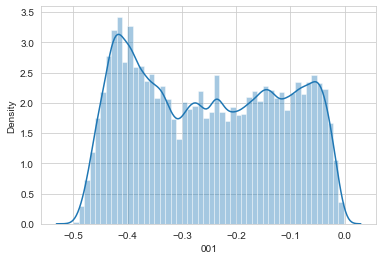

In [44]:
sns.distplot(alphas[f'{alpha:03}']);

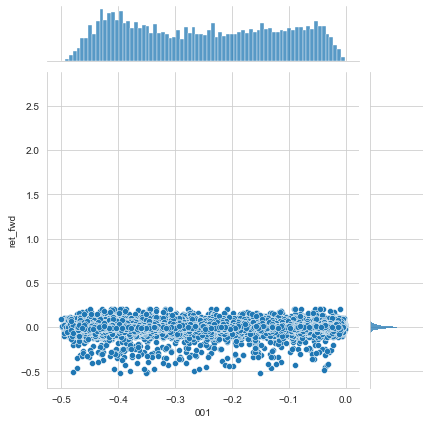

In [45]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [46]:
mi[1] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[1]

0.015509474955528901

## Alpha 002

```
correlation(rank(delta(log(volume), 2)), rank(((close - open) / open)), 6))
```

In [47]:
def alpha002(o, c, v):
    """(-1 * ts_corr(rank(ts_delta(log(volume), 2)), rank(((close - open) / open)), 6))"""
    s1 = rank(ts_delta(log(v), 2))
    s2 = rank((c / o) - 1)
    alpha = -ts_corr(s1, s2, 6)
    return alpha.stack('code').swaplevel().replace([-np.inf, np.inf], np.nan)

In [48]:
alpha = 2

In [49]:
%%time
alphas[f'{alpha:03}'] = alpha002(o, c, v)

CPU times: total: 891 ms
Wall time: 2.43 s


In [50]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

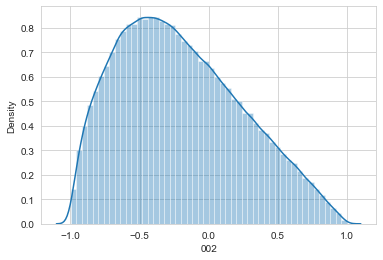

In [51]:
sns.distplot(alphas[f'{alpha:03}']);

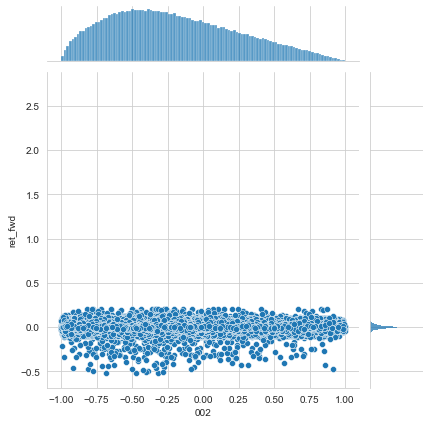

In [52]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [53]:
alphas

returns   ret_fwd       001       002
code      date                                              
sh.600000 2017-07-04       NaN  0.005578       NaN       NaN
          2017-07-05  0.005578  0.003170       NaN       NaN
          2017-07-06  0.003170 -0.004739       NaN       NaN
          2017-07-07 -0.004739 -0.005556       NaN       NaN
          2017-07-10 -0.005556  0.021548       NaN       NaN
...                        ...       ...       ...       ...
sz.300999 2023-06-14  0.010151  0.009804 -0.425514 -0.197214
          2023-06-15  0.009804  0.003398 -0.365582 -0.092264
          2023-06-16  0.003398 -0.009676 -0.359107 -0.159354
          2023-06-19 -0.009676 -0.003664 -0.277491 -0.202850
          2023-06-20 -0.003664 -0.013729 -0.236301 -0.471468

[396941 rows x 4 columns]

In [54]:
f'{alpha:03}'

'002'

In [55]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[2]

0

## Alpha 003

```
(-1 * correlation(rank(open), rank(volume), 10))
```

In [56]:
def alpha003(o, v):
    """(-1 * ts_corr(rank(open), rank(volume), 10))"""

    return (-ts_corr(rank(o), rank(v), 10)
            .stack('code')
            .swaplevel()
            .replace([-np.inf, np.inf], np.nan))

In [57]:
alpha = 3

In [58]:
%%time
alphas[f'{alpha:03}'] = alpha003(o, v)

CPU times: total: 703 ms
Wall time: 3.14 s


In [59]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

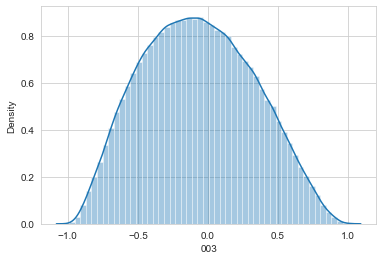

In [60]:
sns.distplot(alphas[f'{alpha:03}'].clip(lower=-1));

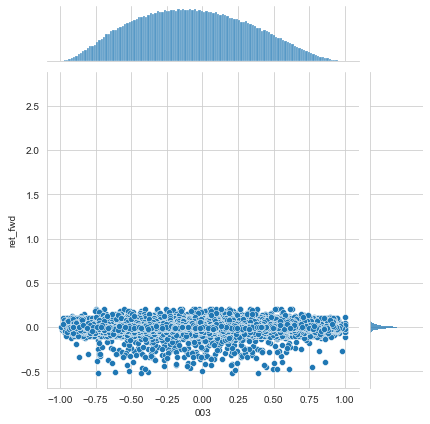

In [61]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [62]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0009346310590210294

## Alpha 004

```
(-1 * Ts_Rank(rank(low), 9))
```

In [63]:
def alpha004(l):
    """(-1 * Ts_Rank(rank(low), 9))"""
    return (-ts_rank(rank(l), 9)
            .stack('code')
            .swaplevel())

In [64]:
alpha = 4

In [65]:
%%time
alphas[f'{alpha:03}'] = alpha004(l)

CPU times: total: 36.4 s
Wall time: 1min 30s


In [66]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

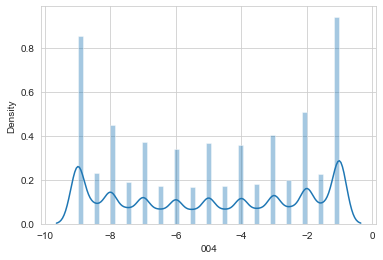

In [67]:
sns.distplot(alphas[f'{alpha:03}']);

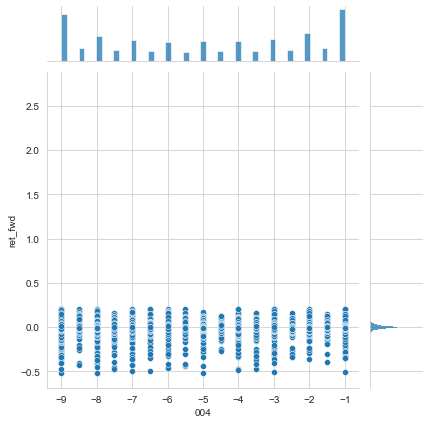

In [68]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [69]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0020835842051738496

## Alpha 005

Very roughly approximating wvap as average of OHLC.

```
(rank((open - (sum(vwap, 10) / 10))) * (-1 * abs(rank((close - vwap)))))
```

In [70]:
def alpha005(o, vwap, c):
    """(rank((open - ts_mean(vwap, 10))) * (-1 * abs(rank((close - vwap)))))"""
    return (rank(o.sub(ts_mean(vwap, 10)))
            .mul(rank(c.sub(vwap)).mul(-1).abs())
            .stack('code')
            .swaplevel())

In [71]:
alpha = 5

In [72]:
%%time
alphas[f'{alpha:03}'] = alpha005(o, vwap, c)

CPU times: total: 312 ms
Wall time: 941 ms


In [73]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

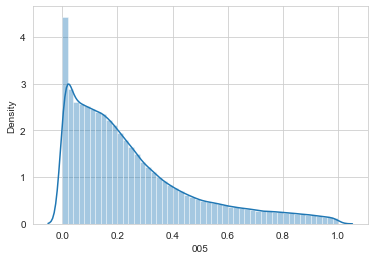

In [74]:
sns.distplot(alphas[f'{alpha:03}']);

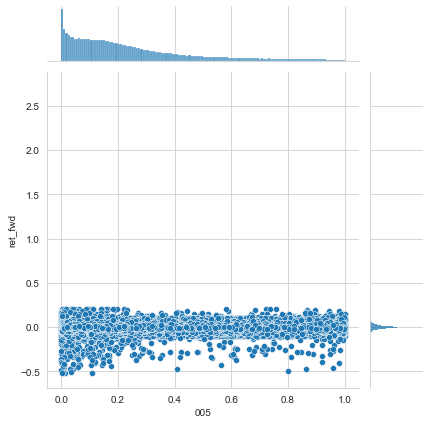

In [75]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [76]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.015058005894392323

## Alpha 006

```
-ts_corr(open, volume, 10)
```

In [77]:
def alpha006(o, v):
    """(-ts_corr(open, volume, 10))"""
    return (-ts_corr(o, v, 10)
            .stack('code')
            .swaplevel())

In [78]:
alpha = 6

In [79]:
%%time
alphas[f'{alpha:03}'] = alpha006(o, v)

CPU times: total: 1.08 s
Wall time: 2.56 s


In [80]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [81]:
alphas[alphas[f'{alpha:03}'] > 100]

Empty DataFrame
Columns: [returns, ret_fwd, 001, 002, 003, 004, 005, 006]
Index: []

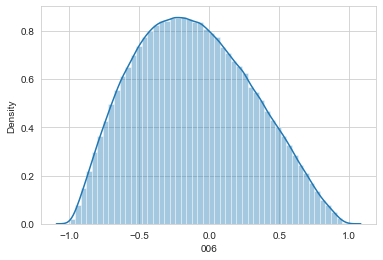

In [82]:
sns.distplot(alphas[f'{alpha:03}']);

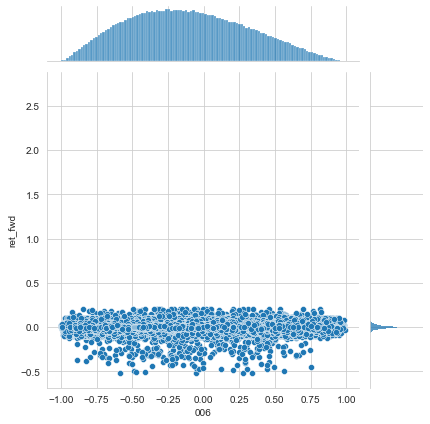

In [83]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [84]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [85]:
mi[alpha]

0.0010989850016338565

## Alpha 007

```
(adv20 < volume) 
? ((-1 * ts_rank(abs(ts_delta(close, 7)), 60)) * sign(ts_delta(close, 7))) 
: -1
```

In [86]:
def alpha007(c, v, adv20):
    """(adv20 < volume) 
        ? ((-ts_rank(abs(ts_delta(close, 7)), 60)) * sign(ts_delta(close, 7))) 
        : -1
    """
    
    delta7 = ts_delta(c, 7)
    return (-ts_rank(abs(delta7), 60)
            .mul(sign(delta7))
            .where(adv20<v, -1)
            .stack('code')
            .swaplevel())

In [87]:
alpha = 7

In [88]:
%%time
alphas[f'{alpha:03}'] = alpha007(c, v, adv20)

CPU times: total: 29.1 s
Wall time: 1min 11s


In [89]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

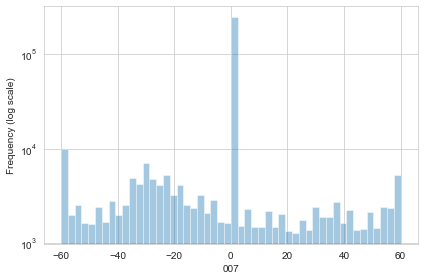

In [90]:
ax = sns.distplot(alphas[f'{alpha:03}'], kde=False)
ax.set_yscale('log')
ax.set_ylabel('Frequency (log scale)')
plt.tight_layout();

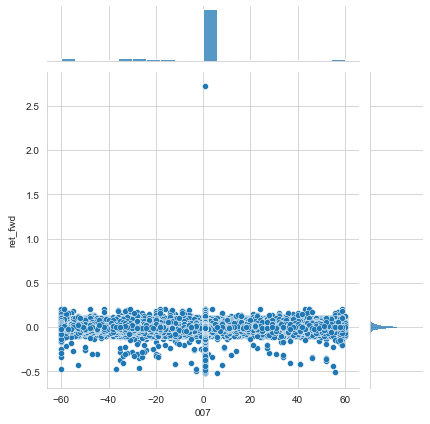

In [91]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [92]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [93]:
mi[alpha]

0.007596212641816091

## Alpha 008

```
-rank(((ts_sum(open, 5) * ts_sum(returns, 5)) - ts_lag((ts_sum(open, 5) * ts_sum(returns, 5)),10)))
```

In [94]:
def alpha008(o, r):
    """-rank(((ts_sum(open, 5) * ts_sum(returns, 5)) - 
        ts_lag((ts_sum(open, 5) * ts_sum(returns, 5)),10)))
    """
    return (-(rank(((ts_sum(o, 5) * ts_sum(r, 5)) -
                       ts_lag((ts_sum(o, 5) * ts_sum(r, 5)), 10))))
           .stack('code')
            .swaplevel())

In [95]:
alpha = 8

In [96]:
%%time
alphas[f'{alpha:03}'] = alpha008(o, r)

CPU times: total: 297 ms
Wall time: 936 ms


In [97]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

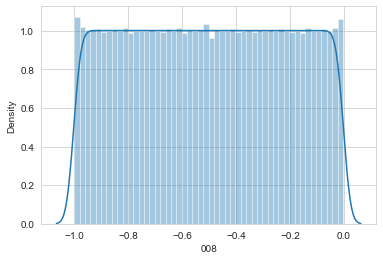

In [98]:
sns.distplot(alphas[f'{alpha:03}']);

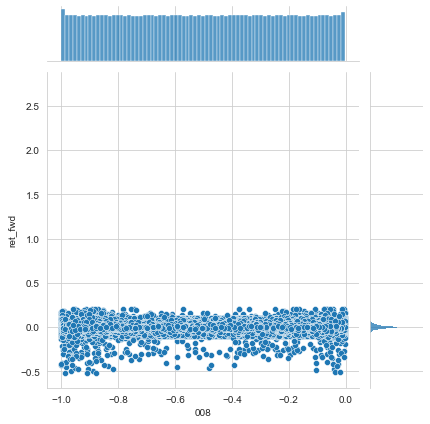

In [99]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [100]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [101]:
mi[alpha]

0.012655543735215602

## Alpha 009

```
(0 < ts_min(ts_delta(close, 1), 5)) ? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 5) < 0) 
? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))
```

In [102]:
def alpha009(c):
    """(0 < ts_min(ts_delta(close, 1), 5)) ? ts_delta(close, 1) 
    : ((ts_max(ts_delta(close, 1), 5) < 0) 
    ? ts_delta(close, 1) : (-1 * ts_delta(close, 1)))
    """
    close_diff = ts_delta(c, 1)
    alpha = close_diff.where(ts_min(close_diff, 5) > 0,
                             close_diff.where(ts_max(close_diff, 5) < 0,
                                              -close_diff))
    return (alpha
            .stack('code')
            .swaplevel())

In [103]:
alpha = 9

In [104]:
%%time
alphas[f'{alpha:03}'] = alpha009(c)

CPU times: total: 719 ms
Wall time: 1.06 s


In [105]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

<AxesSubplot:xlabel='009', ylabel='Density'>

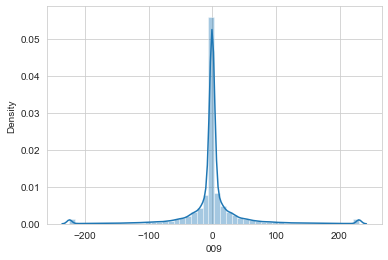

In [106]:
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1-q)))

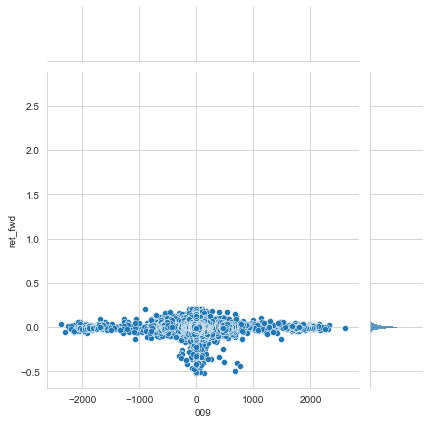

In [107]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [108]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [109]:
mi[alpha]

0.20367912427025026

In [110]:
pd.Series(mi)

1    0.015509
2    0.000000
3    0.000935
4    0.002084
5    0.015058
6    0.001099
7    0.007596
8    0.012656
9    0.203679
dtype: float64

## Alpha 010

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [111]:
def alpha010(c):
    """rank(((0 < ts_min(ts_delta(close, 1), 4)) 
        ? ts_delta(close, 1) 
        : ((ts_max(ts_delta(close, 1), 4) < 0)
            ? ts_delta(close, 1) 
            : (-1 * ts_delta(close, 1)))))
    """
    close_diff = ts_delta(c, 1)
    alpha = close_diff.where(ts_min(close_diff, 4) > 0,
                             close_diff.where(ts_min(close_diff, 4) > 0,
                                              -close_diff))

    return (rank(alpha)
            .stack('code')
            .swaplevel())

In [112]:
alpha = 10

In [113]:
%%time
alphas[f'{alpha:03}'] = alpha010(c)

CPU times: total: 1.11 s
Wall time: 2.4 s


In [114]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

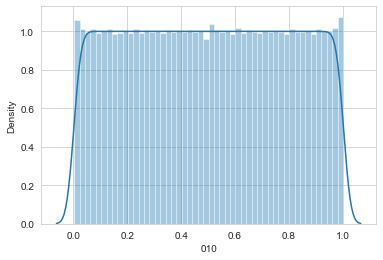

In [115]:
sns.distplot(alphas[f'{alpha:03}']);

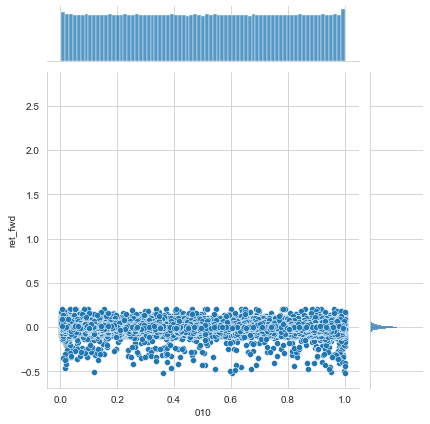

In [116]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [117]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [118]:
mi[alpha]

0.004566547678201971

In [119]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 011

```
((rank(ts_max((vwap - close), 3)) + rank(ts_min((vwap - close), 3))) *rank(ts_delta(volume, 3)))
```

In [120]:
def alpha011(c, vwap, v):
    """(rank(ts_max((vwap - close), 3)) + 
        rank(ts_min(vwap - close), 3)) * 
        rank(ts_delta(volume, 3))
        """
    return (rank(ts_max(vwap.sub(c), 3))
            .add(rank(ts_min(vwap.sub(c), 3)))
            .mul(rank(ts_delta(v, 3)))
            .stack('code')
            .swaplevel())

In [121]:
alpha = 11

In [122]:
%%time
alphas[f'{alpha:03}'] = alpha011(c, vwap, v)

CPU times: total: 469 ms
Wall time: 1.05 s


In [123]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

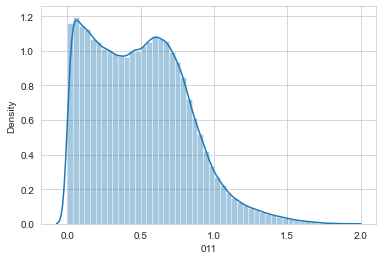

In [124]:
sns.distplot(alphas[f'{alpha:03}']);

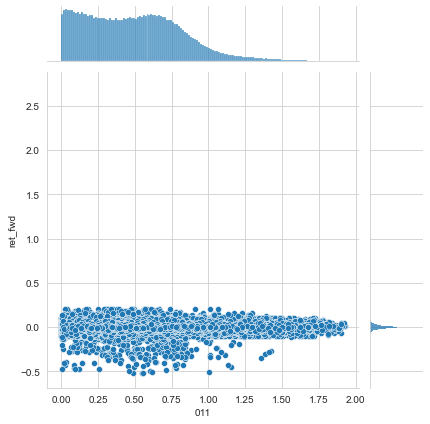

In [125]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [126]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [127]:
mi[alpha]

0

## Alpha 012

```
sign(ts_delta(volume, 1)) * -ts_delta(close, 1)
```

In [128]:
def alpha012(v, c):
    """(sign(ts_delta(volume, 1)) * 
            (-1 * ts_delta(close, 1)))
        """
    return (sign(ts_delta(v, 1)).mul(-ts_delta(c, 1))
            .stack('code')
            .swaplevel())

In [129]:
alpha = 12

In [130]:
%%time
alphas[f'{alpha:03}'] = alpha012(v, c)

CPU times: total: 547 ms
Wall time: 1.44 s


In [131]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

<AxesSubplot:xlabel='012', ylabel='Density'>

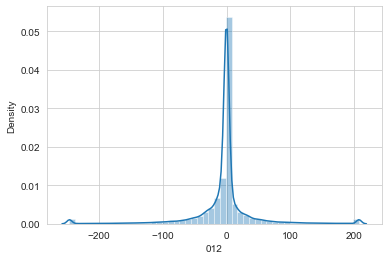

In [132]:
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1-q)))

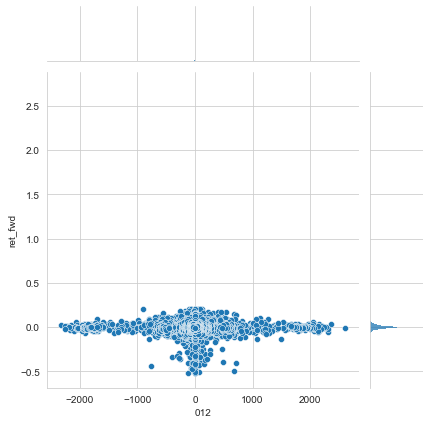

In [133]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)

In [134]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [135]:
mi[alpha]

0.18502909187858396

## Alpha 013

```
-rank(ts_cov(rank(close), rank(volume), 5))
```

In [136]:
def alpha013(c, v):
    """-rank(ts_cov(rank(close), rank(volume), 5))"""
    return (-rank(ts_cov(rank(c), rank(v), 5))
            .stack('code')
            .swaplevel())

In [137]:
alpha = 13

In [138]:
%%time
alphas[f'{alpha:03}'] = alpha013(c, v)

CPU times: total: 578 ms
Wall time: 1.52 s


In [139]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

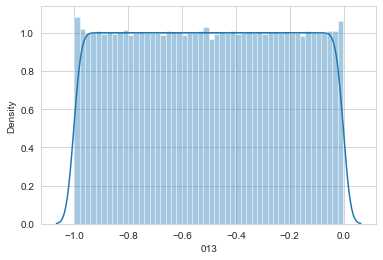

In [140]:
sns.distplot(alphas[f'{alpha:03}']);

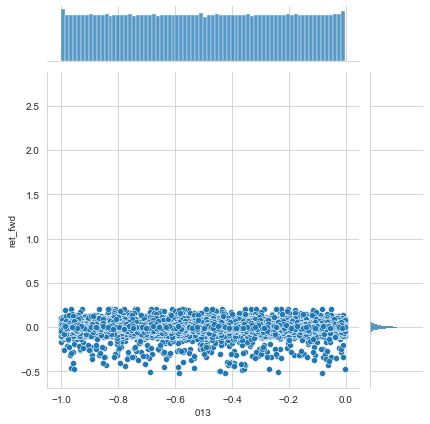

In [141]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [142]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [143]:
mi[alpha]

0

In [144]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 014

```
(-rank(ts_delta(returns, 3))) * ts_corr(open, volume, 10))
```

In [145]:
def alpha014(o, v, r):
    """
    (-rank(ts_delta(returns, 3))) * ts_corr(open, volume, 10))
    """

    alpha = -rank(ts_delta(r, 3)).mul(ts_corr(o, v, 10)
                                      .replace([-np.inf,
                                                np.inf],
                                               np.nan))
    return (alpha
            .stack('code')
            .swaplevel())

In [146]:
alpha = 14

In [147]:
%%time
alphas[f'{alpha:03}'] = alpha014(o, v, r)

CPU times: total: 1.83 s
Wall time: 4.11 s


In [148]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

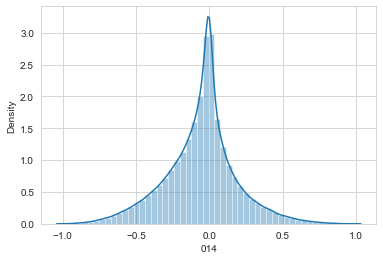

In [149]:
sns.distplot(alphas[f'{alpha:03}']);

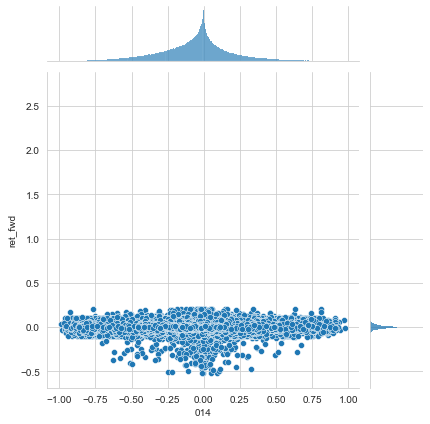

In [150]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [151]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [152]:
mi[alpha]

0.0020486743767120785

## Alpha 015

```
(-1 * ts_sum(rank(ts_corr(rank(high), rank(volume), 3)), 3))
```

In [153]:
def alpha015(h, v):
    """(-1 * ts_sum(rank(ts_corr(rank(high), rank(volume), 3)), 3))"""
    alpha = (-ts_sum(rank(ts_corr(rank(h), rank(v), 3)
                          .replace([-np.inf, np.inf], np.nan)), 3))
    return (alpha
            .stack('code')
            .swaplevel())

In [154]:
alpha = 15

In [155]:
%%time
alphas[f'{alpha:03}'] = alpha015(h, v)

CPU times: total: 641 ms
Wall time: 2.11 s


In [156]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

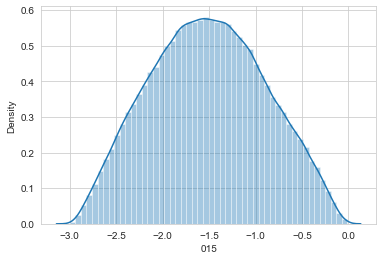

In [157]:
sns.distplot(alphas[f'{alpha:03}']);

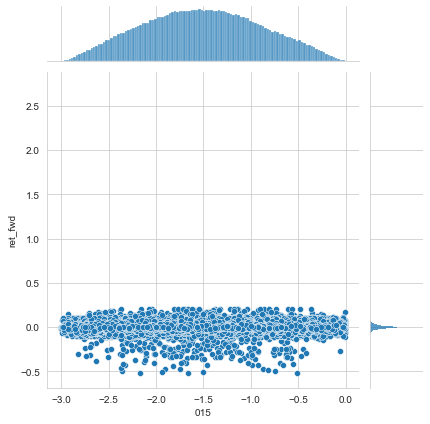

In [158]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [159]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [160]:
mi[alpha]

0

## Alpha 016

```
(-1 * rank(ts_cov(rank(high), rank(volume), 5)))```

In [161]:
def alpha016(h, v):
    """(-1 * rank(ts_cov(rank(high), rank(volume), 5)))"""
    return (-rank(ts_cov(rank(h), rank(v), 5))
            .stack('code')
            .swaplevel())

In [162]:
alpha = 16

In [163]:
%%time
alphas[f'{alpha:03}'] = alpha016(h, v)

CPU times: total: 516 ms
Wall time: 1.65 s


In [164]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

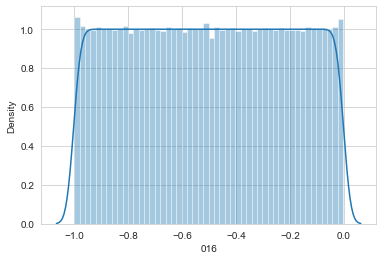

In [165]:
sns.distplot(alphas[f'{alpha:03}']);

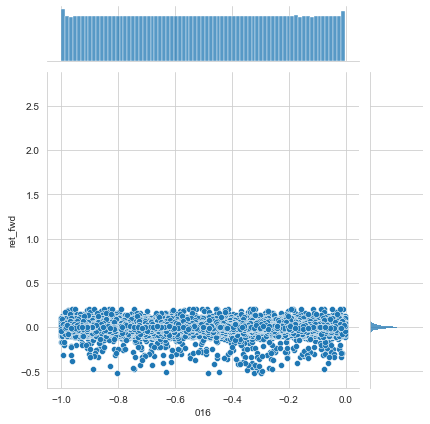

In [166]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);

In [167]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [168]:
mi[alpha]

0.005446876321312466

In [169]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 017

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [170]:
def alpha017(c, v):
    """(((-1 * rank(ts_rank(close, 10))) * rank(ts_delta(ts_delta(close, 1), 1))) *rank(ts_rank((volume / adv20), 5)))
        """
    adv20 = ts_mean(v, 20)
    return (-rank(ts_rank(c, 10))
            .mul(rank(ts_delta(ts_delta(c, 1), 1)))
            .mul(rank(ts_rank(v.div(adv20), 5)))
            .stack('code')
            .swaplevel())

In [171]:
alpha = 17

In [172]:
%%time
alphas[f'{alpha:03}'] = alpha017(c, v)

CPU times: total: 1min 4s
Wall time: 2min 36s


In [173]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

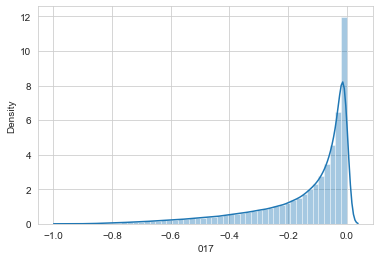

In [174]:
sns.distplot(alphas[f'{alpha:03}']);

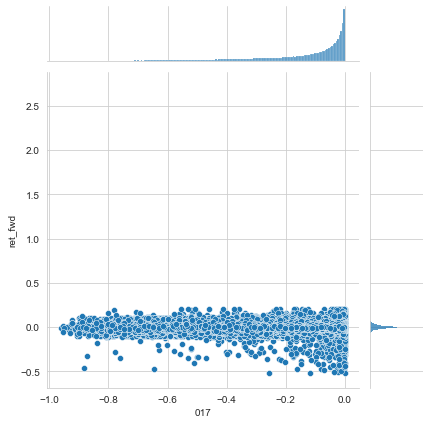

In [175]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [176]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [177]:
mi[alpha]

0

## Alpha 018

```
-rank((ts_std(abs((close - open)), 5) + (close - open)) +
            ts_corr(close, open,10))
```

In [178]:
def alpha018(o, c):
    """-rank((ts_std(abs((close - open)), 5) + (close - open)) +
            ts_corr(close, open,10))
    """
    return (-rank(ts_std(c.sub(o).abs(), 5)
                  .add(c.sub(o))
                  .add(ts_corr(c, o, 10)
                       .replace([-np.inf,
                                 np.inf],
                                np.nan)))
            .stack('code')
            .swaplevel())

In [179]:
alpha = 18

In [180]:
%%time
alphas[f'{alpha:03}'] = alpha018(o, c)

CPU times: total: 1.12 s
Wall time: 2.66 s


In [181]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

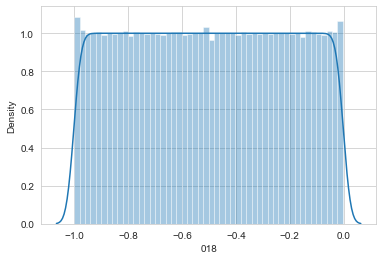

In [182]:
sns.distplot(alphas[f'{alpha:03}']);

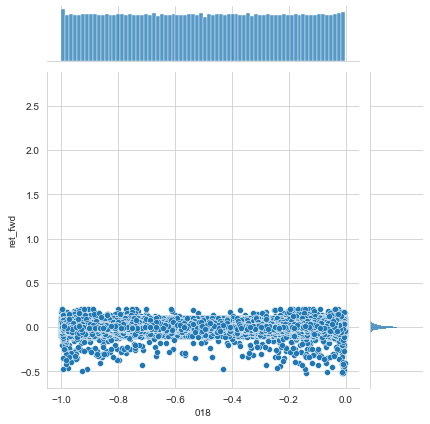

In [183]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [184]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [185]:
mi[alpha]

0.013104802969531093

## Alpha 019

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [186]:
def alpha019(c, r):
    """((-1 * sign(((close - ts_lag(close, 7)) + ts_delta(close, 7)))) * 
    (1 + rank((1 + ts_sum(returns,250)))))
    """
    return (-sign(ts_delta(c, 7) + ts_delta(c, 7))
            .mul(1 + rank(1 + ts_sum(r, 250)))
            .stack('code')
            .swaplevel())

In [187]:
alpha = 19

In [188]:
%%time
alphas[f'{alpha:03}'] = alpha019(c, r)

CPU times: total: 656 ms
Wall time: 1.55 s


In [189]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

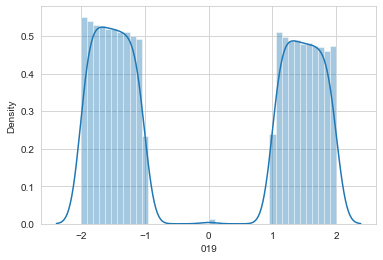

In [190]:
sns.distplot(alphas[f'{alpha:03}']);

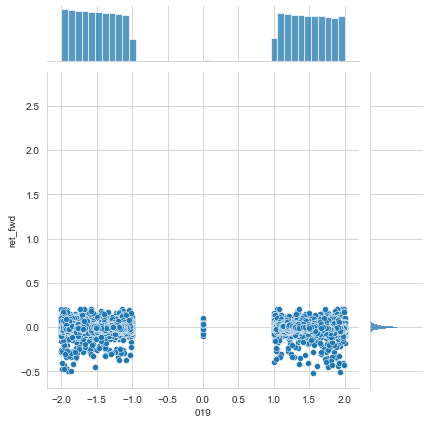

In [191]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [192]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [193]:
mi[alpha]

0.01472914011803983

In [194]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 020

```
-rank(open - ts_lag(high, 1)) * 
 rank(open - ts_lag(close, 1)) * 
 rank(open -ts_lag(low, 1))
```

In [195]:
def alpha020(o, h, l, c):
    """-rank(open - ts_lag(high, 1)) * 
        rank(open - ts_lag(close, 1)) * 
        rank(open -ts_lag(low, 1))"""
    return (rank(o - ts_lag(h, 1))
            .mul(rank(o - ts_lag(c, 1)))
            .mul(rank(o - ts_lag(l, 1)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [196]:
alpha = 20

In [197]:
%%time
alphas[f'{alpha:03}'] = alpha020(o, h, l, c)

CPU times: total: 328 ms
Wall time: 963 ms


In [198]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

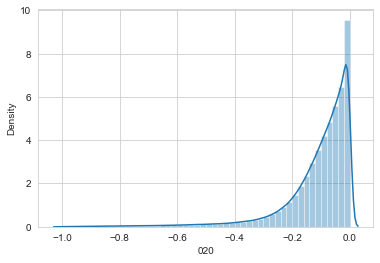

In [199]:
sns.distplot(alphas[f'{alpha:03}']);

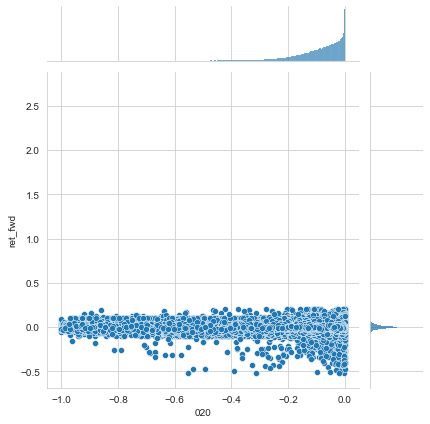

In [200]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [201]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [202]:
mi[alpha]

0.004002764984156748

## Alpha 021

```
ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2)
        ? -1 
        : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8)
            ? 1 
            : (volume / adv20 < 1
                ? -1 
                : 1))
```

In [203]:
def alpha021(c, v):
    """ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2)
        ? -1
        : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8)
            ? 1
            : (volume / adv20 < 1
                ? -1
                : 1))
    """
    sma2 = ts_mean(c, 2)
    sma8 = ts_mean(c, 8)
    std8 = ts_std(c, 8)

    cond_1 = sma8.add(std8) < sma2
    cond_2 = sma8.add(std8) > sma2
    cond_3 = v.div(ts_mean(v, 20)) < 1

    val = np.ones_like(c)
    alpha = pd.DataFrame(np.select(condlist=[cond_1, cond_2, cond_3],
                                   choicelist=[-1, 1, -1], default=1),
                         index=c.index,
                         columns=c.columns)

    return (alpha
            .stack('code')
            .swaplevel())

In [204]:
alpha = 21

In [205]:
%%time
alphas[f'{alpha:03}'] = alpha021(c, v)

CPU times: total: 484 ms
Wall time: 1.46 s


In [206]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [207]:
alphas[f'{alpha:03}'].value_counts()

 1    379903
-1     17038
Name: 021, dtype: int64

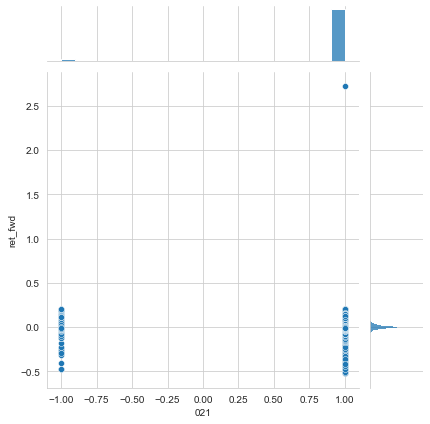

In [208]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [209]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [210]:
mi[alpha]

0.0007973944634112051

## Alpha 022

```
-(ts_delta(ts_corr(high, volume, 5), 5) * 
        rank(ts_std(close, 20)))
```

In [211]:
def alpha022(h, c, v):
    """-(ts_delta(ts_corr(high, volume, 5), 5) * 
        rank(ts_std(close, 20)))
    """

    return (ts_delta(ts_corr(h, v, 5)
                     .replace([-np.inf,
                               np.inf],
                              np.nan), 5)
            .mul(rank(ts_std(c, 20)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [212]:
alpha = 22

In [213]:
%%time
alphas[f'{alpha:03}'] = alpha022(h, c, v)

CPU times: total: 578 ms
Wall time: 1.83 s


In [214]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

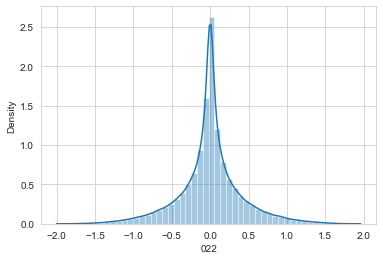

In [215]:
sns.distplot(alphas[f'{alpha:03}']);

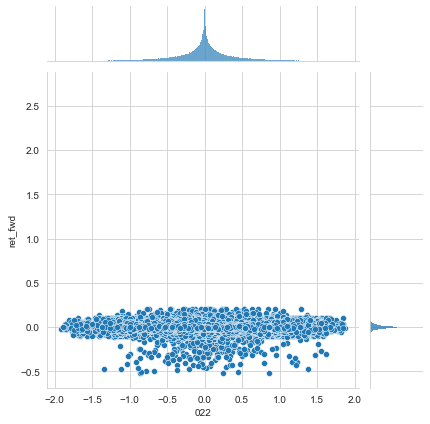

In [216]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [217]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [218]:
mi[alpha]

0.011823555475161562

In [219]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 023

```
((ts_sum(high, 20) / 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
```

In [220]:
def alpha023(h, c):
    """((ts_mean(high, 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
        """

    return (ts_delta(h, 2)
            .mul(-1)
            .where(ts_mean(h, 20) < h, 0)
            .stack('code')
            .swaplevel())

In [221]:
alpha = 23

In [222]:
%%time
alphas[f'{alpha:03}'] = alpha023(h, c)

CPU times: total: 406 ms
Wall time: 881 ms


In [223]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

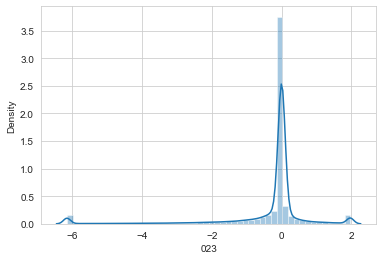

In [224]:
q = 0.025
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1-q)));

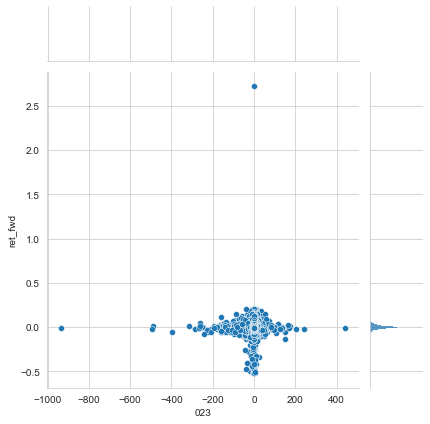

In [225]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [226]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [227]:
mi[alpha]

0.019449020601853384

## Alpha 024

```
((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05)  
        ? (-1 * (close - ts_min(close, 100))) 
        : (-1 * ts_delta(close, 3)))
```

In [228]:
def alpha024(c):
    """((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05)  
        ? (-1 * (close - ts_min(close, 100))) 
        : (-1 * ts_delta(close, 3)))
    """
    cond = ts_delta(ts_mean(c, 100), 100) / ts_lag(c, 100) <= 0.05

    return (c.sub(ts_min(c, 100)).mul(-1).where(cond, -ts_delta(c, 3))
            .stack('code')
            .swaplevel())

In [229]:
alpha = 24

In [230]:
%%time
alphas[f'{alpha:03}'] = alpha024(c)

CPU times: total: 516 ms
Wall time: 891 ms


In [231]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

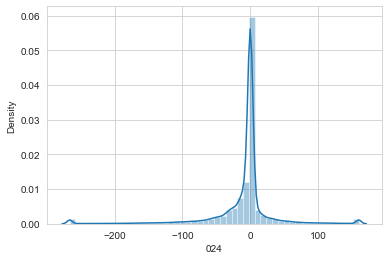

In [232]:
q = 0.01
sns.distplot(alphas[f'{alpha:03}'].clip(lower=alphas[f'{alpha:03}'].quantile(q),
                                        upper=alphas[f'{alpha:03}'].quantile(1-q)));

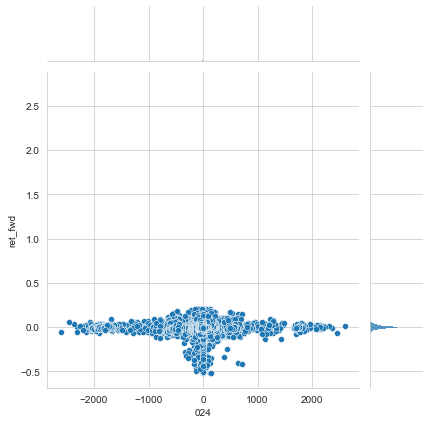

In [233]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [234]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [235]:
mi[alpha]

0.21031650848585848

## Alpha 025

```
rank((-1 * returns) * adv20 * vwap * (high - close))
```

In [236]:
def alpha025(h, c, r, vwap, adv20):
    """rank((-1 * returns) * adv20 * vwap * (high - close))"""
    return (rank(-r.mul(adv20)
                 .mul(vwap)
                 .mul(h.sub(c)))
            .stack('code')
            .swaplevel())

In [237]:
alpha = 25

In [238]:
%%time
alphas[f'{alpha:03}'] = alpha025(h, c, r, vwap, adv20)

CPU times: total: 406 ms
Wall time: 831 ms


In [239]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

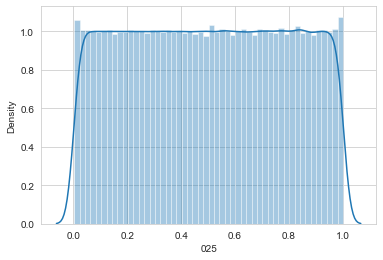

In [240]:
sns.distplot(alphas[f'{alpha:03}']);

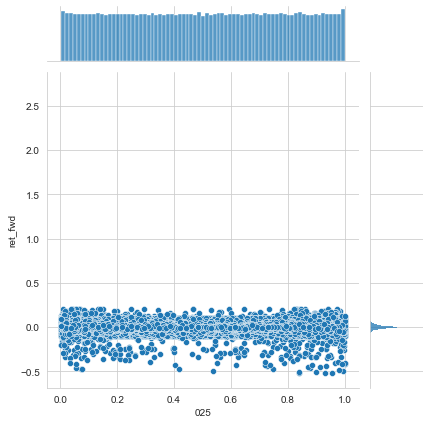

In [241]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [242]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [243]:
mi[alpha]

0.014309439189149842

In [244]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 026

```
(-1 * rank(ts_cov(rank(high), rank(volume), 5)))```

In [245]:
def alpha026(h, v):
    """(-1 * ts_max(ts_corr(ts_rank(volume, 5), ts_rank(high, 5), 5), 3))"""
    return (ts_max(ts_corr(ts_rank(v, 5), 
                           ts_rank(h, 5), 5)
                   .replace([-np.inf, np.inf], np.nan), 3)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [246]:
alpha = 26

In [247]:
%%time
alphas[f'{alpha:03}'] = alpha026(h, v)

CPU times: total: 1min 17s
Wall time: 2min 39s


In [248]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

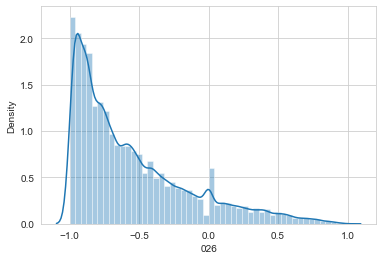

In [249]:
sns.distplot(alphas[f'{alpha:03}']);

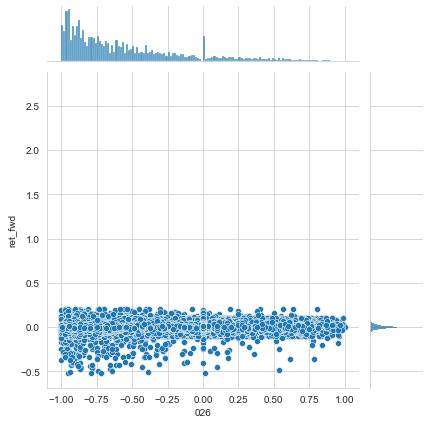

In [250]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [251]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [252]:
mi[alpha]

0.001211604600563021

## Alpha 027

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [253]:
def alpha027(v, vwap):
    """((0.5 < rank(ts_mean(ts_corr(rank(volume), rank(vwap), 6), 2))) 
            ? -1
            : 1)"""
    cond = rank(ts_mean(ts_corr(rank(v),
                                rank(vwap), 6), 2))
    alpha = cond.notnull().astype(float)
    return (alpha.where(cond <= 0.5, -alpha)
            .stack('code')
            .swaplevel())

In [254]:
alpha = 27

In [255]:
%%time
alphas[f'{alpha:03}'] = alpha027(v, vwap)

CPU times: total: 1.17 s
Wall time: 2.37 s


In [256]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

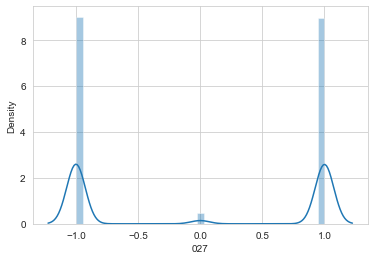

In [257]:
sns.distplot(alphas[f'{alpha:03}']);

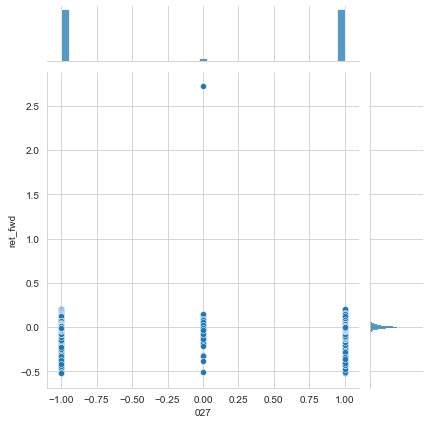

In [258]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [259]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [260]:
mi[alpha]

0

## Alpha 028

```
-rank((ts_std(abs((close - open)), 5) + (close - open)) +
            ts_corr(close, open,10))
```

In [261]:
def alpha028(h, l, c, v, adv20):
    """scale(((ts_corr(adv20, low, 5) + (high + low) / 2) - close))"""
    return (scale(ts_corr(adv20, l, 5)
                  .replace([-np.inf, np.inf], 0)
                  .add(h.add(l).div(2).sub(c)))
            .stack('code')
            .swaplevel())

In [262]:
alpha = 28

In [263]:
%%time
alphas[f'{alpha:03}'] = alpha028(h, l, c, v, adv20)

CPU times: total: 859 ms
Wall time: 1.89 s


In [264]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

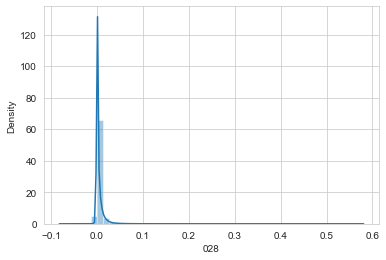

In [265]:
sns.distplot(alphas[f'{alpha:03}']);

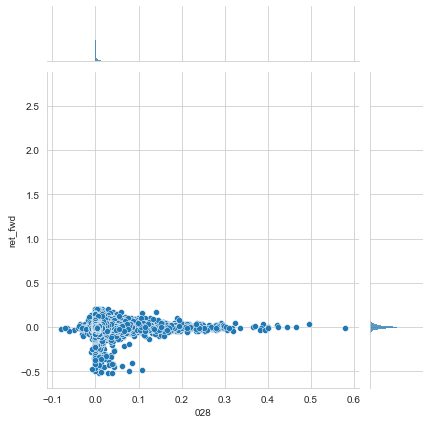

In [266]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [267]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [268]:
mi[alpha]

0.01408251947711836

In [269]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 029

```
rank(((0 < ts_min(ts_delta(close, 1), 4)) 
? ts_delta(close, 1) 
: ((ts_max(ts_delta(close, 1), 4) < 0)
    ? ts_delta(close, 1) 
    : (-1 * ts_delta(close, 1)))))
```

In [270]:
def alpha029(c, r):
    """(ts_min(ts_product(rank(rank(scale(log(ts_sum(ts_min(rank(rank((-1 * 
            rank(ts_delta((close - 1),5))))), 2), 1))))), 1), 5)
        + ts_rank(ts_lag((-1 * returns), 6), 5))
    """
    return (ts_min(rank(rank(scale(log(ts_sum(rank(rank(-rank(ts_delta((c - 1), 5)))), 2))))), 5)
            .add(ts_rank(ts_lag((-1 * r), 6), 5))
            .stack('code')
            .swaplevel())

In [271]:
alpha = 29

In [272]:
%%time
alphas[f'{alpha:03}'] = alpha029(c, r)

CPU times: total: 38 s
Wall time: 1min 19s


In [273]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

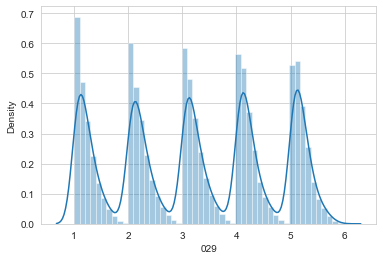

In [274]:
sns.distplot(alphas[f'{alpha:03}']);

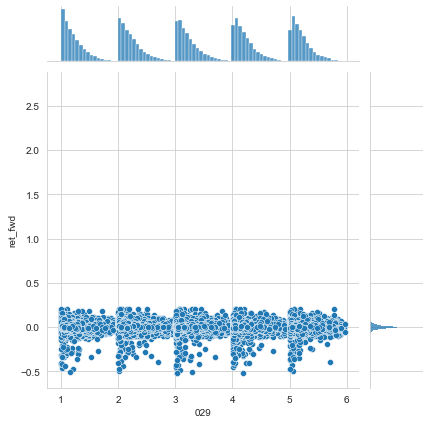

In [275]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [276]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [277]:
mi[alpha]

0.009873458240242883

## Alpha 030

```
-rank(open - ts_lag(high, 1)) * 
 rank(open - ts_lag(close, 1)) * 
 rank(open -ts_lag(low, 1))
```

In [278]:
def alpha030(c, v):
    """(((1.0 - rank(((sign((close - ts_lag(close, 1))) +
            sign((ts_lag(close, 1) - ts_lag(close, 2)))) +
            sign((ts_lag(close, 2) - ts_lag(close, 3)))))) *
            ts_sum(volume, 5)) / ts_sum(volume, 20))"""
    close_diff = ts_delta(c, 1)
    return (rank(sign(close_diff)
                 .add(sign(ts_lag(close_diff, 1)))
                 .add(sign(ts_lag(close_diff, 2))))
            .mul(-1).add(1)
            .mul(ts_sum(v, 5))
            .div(ts_sum(v, 20))
            .stack('code')
            .swaplevel())

In [279]:
alpha = 30

In [280]:
%%time
alphas[f'{alpha:03}'] = alpha030(c, v)

CPU times: total: 344 ms
Wall time: 857 ms


In [281]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

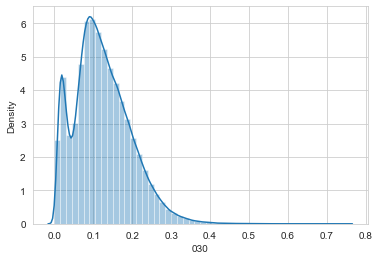

In [282]:
sns.distplot(alphas[f'{alpha:03}']);

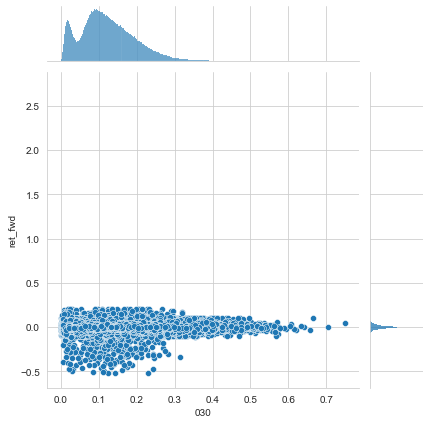

In [283]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [284]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [285]:
mi[alpha]

0

## Alpha 031

```
ts_mean(close, 8) + ts_std(close, 8) < ts_mean(close, 2)
        ? -1 
        : (ts_mean(close,2) < ts_mean(close, 8) - ts_std(close, 8)
            ? 1 
            : (volume / adv20 < 1
                ? -1 
                : 1))
```

In [286]:
def alpha031(l, c, adv20):
    """((rank(rank(rank(ts_weighted_mean((-1 * rank(rank(ts_delta(close, 10)))), 10)))) +
        rank((-1 * ts_delta(close, 3)))) + sign(scale(ts_corr(adv20, low, 12))))
    """
    return (rank(rank(rank(ts_weighted_mean(rank(rank(ts_delta(c, 10))).mul(-1), 10))))
            .add(rank(ts_delta(c, 3).mul(-1)))
            .add(sign(scale(ts_corr(adv20, l, 12)
                            .replace([-np.inf, np.inf],
                                     np.nan))))
            .stack('code')
            .swaplevel())

In [287]:
alpha = 31

In [288]:
%%time
alphas[f'{alpha:03}'] = alpha031(l, c, adv20)

CPU times: total: 953 ms
Wall time: 2.08 s


In [289]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

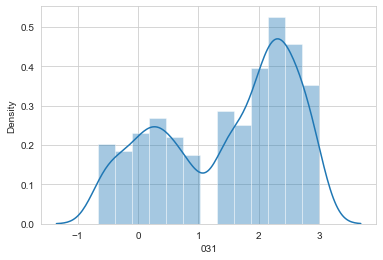

In [290]:
sns.distplot(alphas[f'{alpha:03}']);

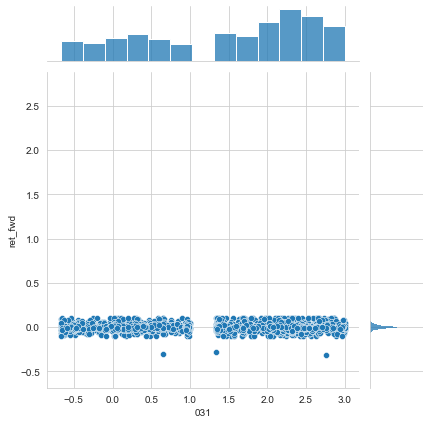

In [291]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 032

```
scale(ts_mean(close, 7) - close) + 
        (20 * scale(ts_corr(vwap, ts_lag(close, 5),230)))```

In [292]:
def alpha032(c, vwap):
    """scale(ts_mean(close, 7) - close) + 
        (20 * scale(ts_corr(vwap, ts_lag(close, 5),230)))"""
    return (scale(ts_mean(c, 7).sub(c))
            .add(20 * scale(ts_corr(vwap,
                                    ts_lag(c, 5), 230)))
            .stack('code')
            .swaplevel())

In [293]:
alpha = 32

In [294]:
%%time
alphas[f'{alpha:03}'] = alpha032(c, vwap)

CPU times: total: 766 ms
Wall time: 1.85 s


In [295]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

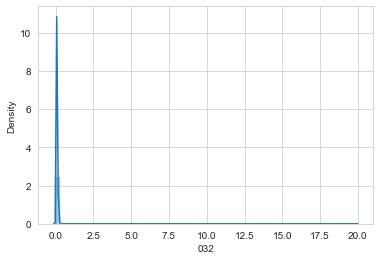

In [296]:
sns.distplot(alphas[f'{alpha:03}']);

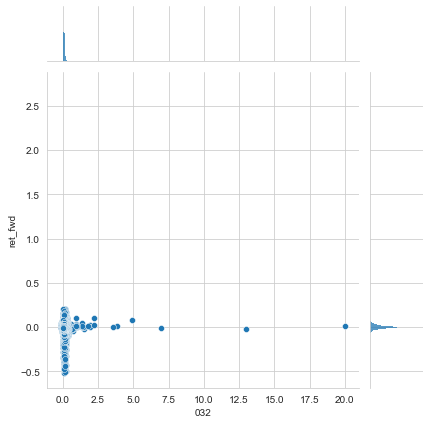

In [297]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [298]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, 
                                  alphas[f'{alpha:03}'])

In [299]:
mi[alpha]

0.012472822014571783

## Alpha 033

```
((ts_sum(high, 20) / 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
```

In [300]:
def alpha033(o, c):
    """rank(-(1 - (open / close)))"""
    return (rank(o.div(c).mul(-1).add(1).mul(-1))
            .stack('code')
            .swaplevel())

In [301]:
alpha = 33

In [302]:
%%time
alphas[f'{alpha:03}'] = alpha033(o, c)

CPU times: total: 844 ms
Wall time: 1.88 s


In [303]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

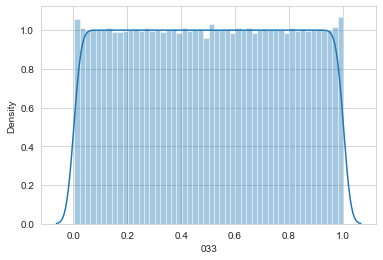

In [304]:
sns.distplot(alphas[f'{alpha:03}']);

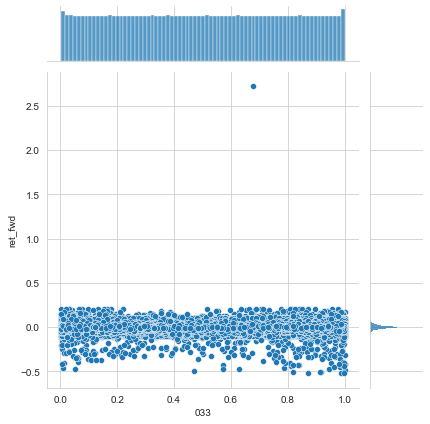

In [305]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [306]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [307]:
mi[alpha]

0.006072344775731153

## Alpha 034

```
((((ts_delta((ts_mean(close, 100)), 100) / ts_lag(close, 100)) <= 0.05)  
        ? (-1 * (close - ts_min(close, 100))) 
        : (-1 * ts_delta(close, 3)))
```

In [308]:
def alpha034(c, r):
    """rank(((1 - rank((ts_std(returns, 2) / ts_std(returns, 5)))) + (1 - rank(ts_delta(close, 1)))))"""

    return (rank(rank(ts_std(r, 2).div(ts_std(r, 5))
                      .replace([-np.inf, np.inf],
                               np.nan))
                 .mul(-1)
                 .sub(rank(ts_delta(c, 1)))
                 .add(2))
            .stack('code')
            .swaplevel())

In [309]:
alpha = 34

In [310]:
%%time
alphas[f'{alpha:03}'] = alpha034(c, r)

CPU times: total: 531 ms
Wall time: 977 ms


In [311]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

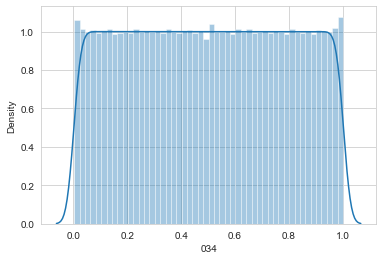

In [312]:
sns.distplot(alphas[f'{alpha:03}']);

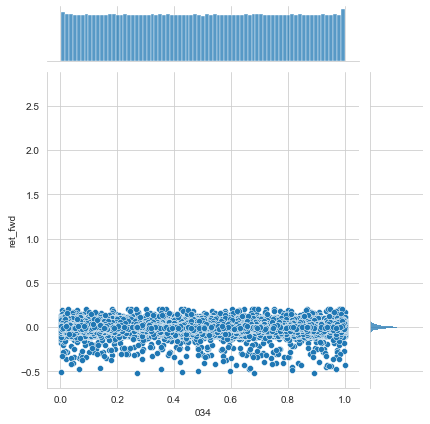

In [313]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [314]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [315]:
mi[alpha]

0

In [316]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 035

```
rank((-1 * returns) * adv20 * vwap * (high - close))
```

In [317]:
def alpha035(h, l, c, v, r):
    """((ts_Rank(volume, 32) *
        (1 - ts_Rank(((close + high) - low), 16))) *
        (1 -ts_Rank(returns, 32)))
    """
    return (ts_rank(v, 32)
            .mul(1 - ts_rank(c.add(h).sub(l), 16))
            .mul(1 - ts_rank(r, 32))
            .stack('code')
            .swaplevel())

In [318]:
alpha = 35

In [319]:
%%time
alphas[f'{alpha:03}'] = alpha035(h, l, c, v, r)

CPU times: total: 1min 47s
Wall time: 3min 42s


In [320]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

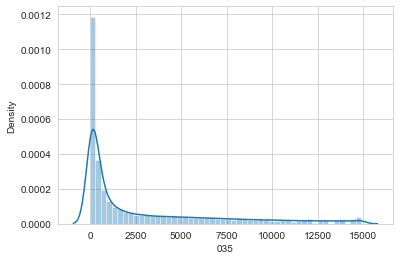

In [321]:
sns.distplot(alphas[f'{alpha:03}']);

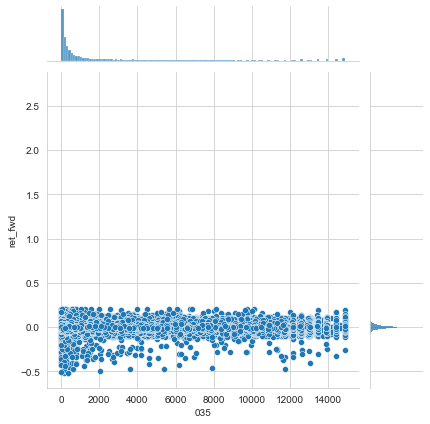

In [322]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [323]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [324]:
mi[alpha]

0.0029105285825750116

## Alpha 036

```
2.21 * rank(ts_corr((close - open), ts_lag(volume, 1), 15)) +
0.7 * rank((open- close)) +
0.73 * rank(ts_Rank(ts_lag(-1 * returns, 6), 5)) +
rank(abs(ts_corr(vwap,adv20, 6))) +
0.6 * rank(((ts_mean(close, 200) - open) * (close - open)))
```

In [325]:
def alpha036(o, c, v, r, adv20):
    """2.21 * rank(ts_corr((close - open), ts_lag(volume, 1), 15)) +
        0.7 * rank((open- close)) +
        0.73 * rank(ts_Rank(ts_lag(-1 * returns, 6), 5)) +
        rank(abs(ts_corr(vwap,adv20, 6))) +
        0.6 * rank(((ts_mean(close, 200) - open) * (close - open)))
    """

    return (rank(ts_corr(c.sub(o), ts_lag(v, 1), 15)).mul(2.21)
            .add(rank(o.sub(c)).mul(.7))
            .add(rank(ts_rank(ts_lag(-r, 6), 5)).mul(0.73))
            .add(rank(abs(ts_corr(vwap, adv20, 6))))
            .add(rank(ts_mean(c, 200).sub(o).mul(c.sub(o))).mul(0.6))
            .stack('code')
            .swaplevel())

In [326]:
alpha = 36

In [327]:
%%time
alphas[f'{alpha:03}'] = alpha036(o, c, v, r, adv20)

CPU times: total: 39.8 s
Wall time: 1min 20s


In [328]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

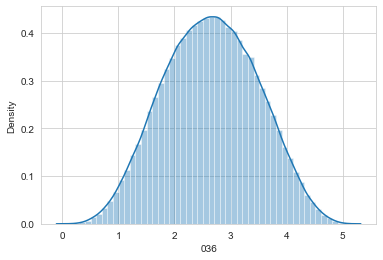

In [329]:
sns.distplot(alphas[f'{alpha:03}']);

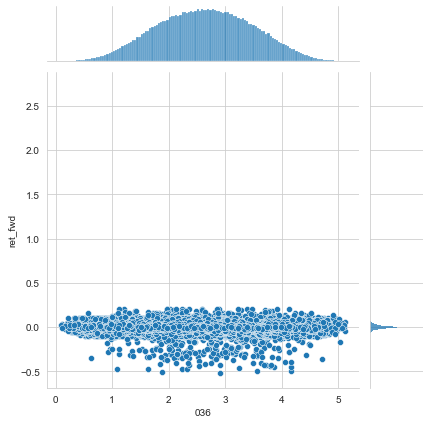

In [330]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [331]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [332]:
mi[alpha]

0.007142811436060548

## Alpha 037

```
rank(ts_corr(ts_lag(open - close, 1), close, 200)) + 
        rank(open - close)
```

In [333]:
def alpha037(o, c):
    """(rank(ts_corr(ts_lag((open - close), 1), close, 200)) + rank((open - close)))"""
    return (rank(ts_corr(ts_lag(o.sub(c), 1), c, 200))
            .add(rank(o.sub(c)))
            .stack('code')
            .swaplevel())

In [334]:
alpha = 37

In [335]:
%%time
alphas[f'{alpha:03}'] = alpha037(o, c)

CPU times: total: 906 ms
Wall time: 1.9 s


In [336]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

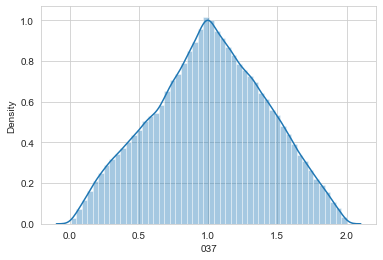

In [337]:
sns.distplot(alphas[f'{alpha:03}']);

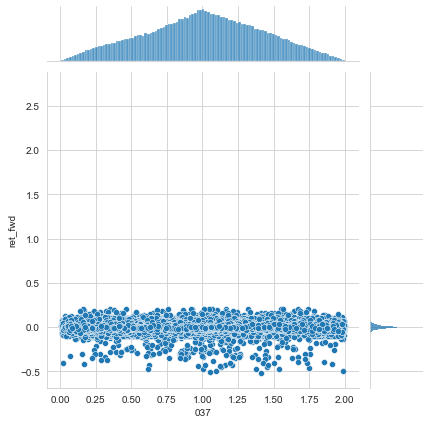

In [338]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [339]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [340]:
mi[alpha]

0

In [341]:
pd.Series(mi).to_csv('mi.csv')

## Alpha 038

```
1 * rank(ts_rank(close, 10)) * rank(close / open)
```

In [342]:
def alpha038(o, c):
    """"-1 * rank(ts_rank(close, 10)) * rank(close / open)"""
    return (rank(ts_rank(o, 10))
            .mul(rank(c.div(o).replace([-np.inf, np.inf], np.nan)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [343]:
alpha = 38

In [344]:
%%time
alphas[f'{alpha:03}'] = alpha038(o, c)

CPU times: total: 38.5 s
Wall time: 1min 19s


In [345]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

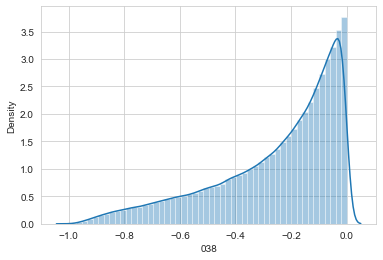

In [346]:
sns.distplot(alphas[f'{alpha:03}']);

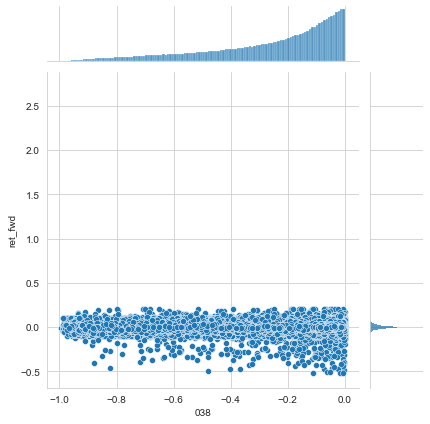

In [347]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [348]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [349]:
mi[alpha]

0.006814164669727951

## Alpha 039

```
-rank(ts_delta(close, 7) * (1 - rank(ts_weighted_mean(volume / adv20, 9)))) * 
    (1 + rank(ts_sum(returns, 250)))
```

In [350]:
def alpha039(c, v, r, adv20):
    """-rank(ts_delta(close, 7) * (1 - rank(ts_weighted_mean(volume / adv20, 9)))) * 
            (1 + rank(ts_sum(returns, 250)))"""
    return (rank(ts_delta(c, 7).mul(rank(ts_weighted_mean(v.div(adv20), 9)).mul(-1).add(1))).mul(-1)
            .mul(rank(ts_mean(r, 250).add(1)))
            .stack('code')
            .swaplevel())

In [351]:
alpha = 39

In [352]:
%%time
alphas[f'{alpha:03}'] = alpha039(c, v, r, adv20)

CPU times: total: 500 ms
Wall time: 970 ms


In [353]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

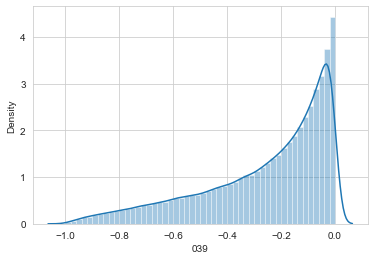

In [354]:
sns.distplot(alphas[f'{alpha:03}']);

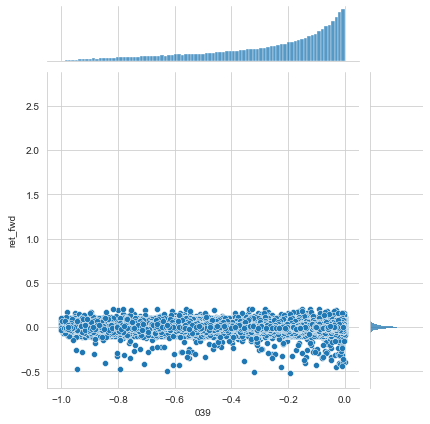

In [355]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [356]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])

In [357]:
mi[alpha]

0.0009722433761387705

## Alpha 040

```
-rank(open - ts_lag(high, 1)) * 
 rank(open - ts_lag(close, 1)) * 
 rank(open -ts_lag(low, 1))
```

In [358]:
def alpha040(h, v):
    """((-1 * rank(ts_std(high, 10))) * ts_corr(high, volume, 10))
    """
    return (rank(ts_std(h, 10))
            .mul(ts_corr(h, v, 10))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [359]:
alpha = 40

In [360]:
%%time
alphas[f'{alpha:03}'] = alpha040(h, v)

CPU times: total: 953 ms
Wall time: 1.84 s


In [361]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

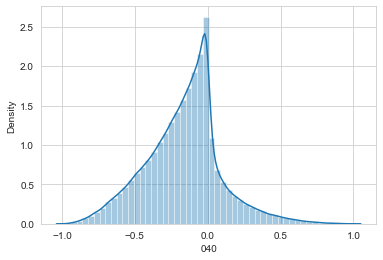

In [362]:
sns.distplot(alphas[f'{alpha:03}']);

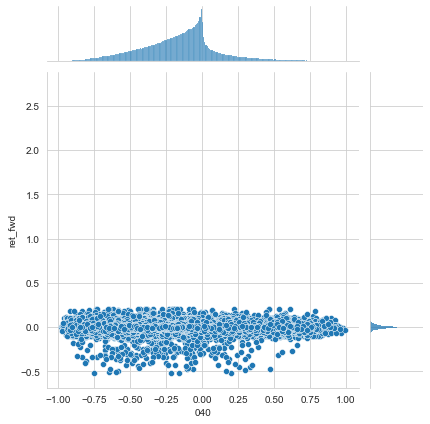

In [363]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [364]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.02788767112265944

## Alpha 041

```
power(high * low, 0.5) - vwap```

In [365]:
def alpha041(h, l, vwap):
    """power(high * low, 0.5 - vwap"""
    return (power(h.mul(l), 0.5)
            .sub(vwap)
            .stack('code')
            .swaplevel())

In [366]:
alpha = 41

In [367]:
%%time
alphas[f'{alpha:03}'] = alpha041(h, l, vwap)

CPU times: total: 641 ms
Wall time: 1.32 s


In [368]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

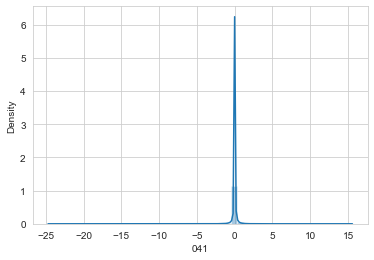

In [369]:
sns.distplot(alphas[f'{alpha:03}']);

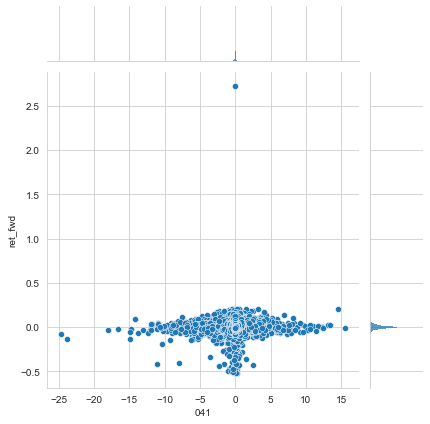

In [370]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [371]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.049640690149280076

## Alpha 042

```
rank(vwap - close) / rank(vwap + close)
```

In [372]:
def alpha042(c, vwap):
    """rank(vwap - close) / rank(vwap + close)"""
    return (rank(vwap.sub(c))
            .div(rank(vwap.add(c)))
            .stack('code')
            .swaplevel())

In [373]:
alpha = 42

In [374]:
%%time
alphas[f'{alpha:03}'] = alpha042(c, vwap)

CPU times: total: 250 ms
Wall time: 845 ms


In [375]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

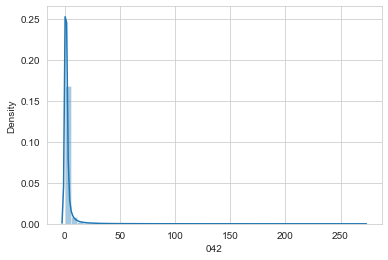

In [376]:
sns.distplot(alphas[f'{alpha:03}']);

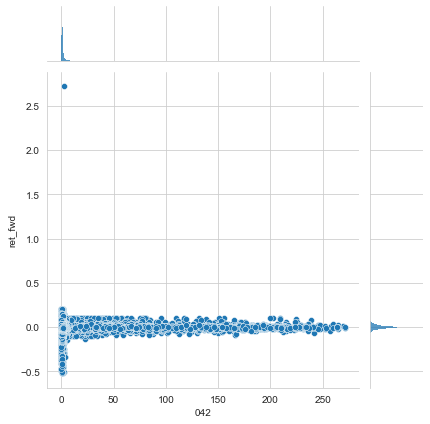

In [377]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [378]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.03448915637589778

## Alpha 043

```
((ts_sum(high, 20) / 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
```

In [379]:
def alpha043(c, adv20):
    """(ts_rank((volume / adv20), 20) * ts_rank((-1 * ts_delta(close, 7)), 8))"""

    return (ts_rank(v.div(adv20), 20)
            .mul(ts_rank(ts_delta(c, 7).mul(-1), 8))
            .stack('code')
            .swaplevel())

In [380]:
alpha = 43

In [381]:
%%time
alphas[f'{alpha:03}'] = alpha043(c, adv20)

CPU times: total: 1min 11s
Wall time: 2min 39s


In [382]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

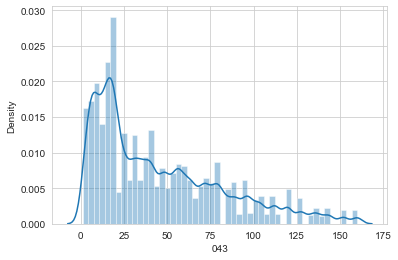

In [383]:
sns.distplot(alphas[f'{alpha:03}']);

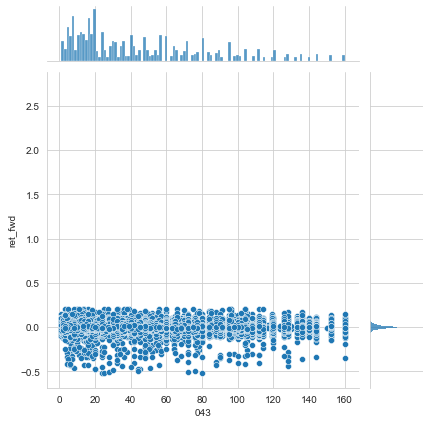

In [384]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [385]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0029968447705179813

## Alpha 044

```
-ts_corr(high, rank(volume), 5)
```

In [386]:
def alpha044(h, v):
    """-ts_corr(high, rank(volume), 5)"""

    return (ts_corr(h, rank(v), 5)
            .replace([-np.inf, np.inf], np.nan)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [387]:
alpha = 44

In [388]:
%%time
alphas[f'{alpha:03}'] = alpha044(h, v)

CPU times: total: 828 ms
Wall time: 1.87 s


In [389]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

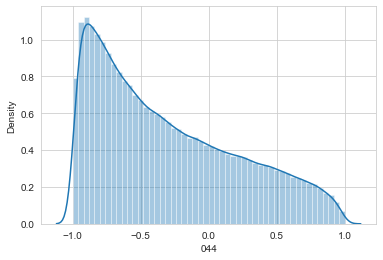

In [390]:
sns.distplot(alphas[f'{alpha:03}']);

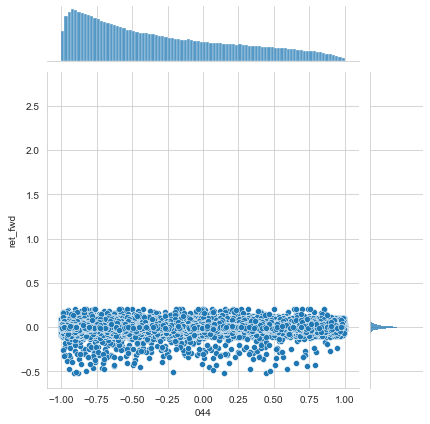

In [391]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [392]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 045

```
-(rank((ts_mean(ts_lag(close, 5), 20)) * 
        ts_corr(close, volume, 2)) *
        rank(ts_corr(ts_sum(close, 5), ts_sum(close, 20), 2)))
```

In [393]:
def alpha045(c, v):
    """-(rank((ts_mean(ts_lag(close, 5), 20)) * 
        ts_corr(close, volume, 2)) *
        rank(ts_corr(ts_sum(close, 5), ts_sum(close, 20), 2)))"""

    return (rank(ts_mean(ts_lag(c, 5), 20))
            .mul(ts_corr(c, v, 2)
                 .replace([-np.inf, np.inf], np.nan))
            .mul(rank(ts_corr(ts_sum(c, 5),
                              ts_sum(c, 20), 2)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [394]:
alpha = 45

In [395]:
%%time
alphas[f'{alpha:03}'] = alpha045(c, v)

CPU times: total: 1.5 s
Wall time: 3.25 s


In [396]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

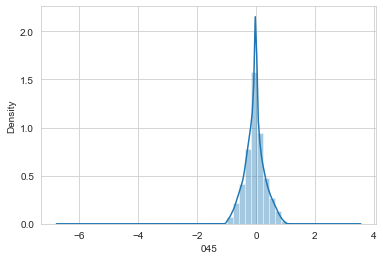

In [397]:
sns.distplot(alphas[f'{alpha:03}']);

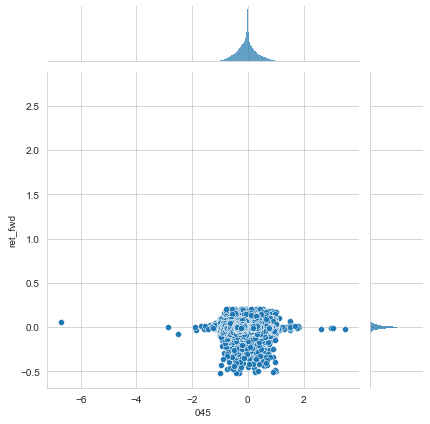

In [398]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [399]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.014361701064646404

## Alpha 046

```
0.25 < ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10
    ? -1
    : ((ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10 < 0) 
        ? 1 
        : -ts_delta(close, 1))
```

In [400]:
def alpha046(c):
    """0.25 < ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10
            ? -1
            : ((ts_lag(ts_delta(close, 10), 10) / 10 - ts_delta(close, 10) / 10 < 0) 
                ? 1 
                : -ts_delta(close, 1))
    """

    cond = ts_lag(ts_delta(c, 10), 10).div(10).sub(ts_delta(c, 10).div(10))
    alpha = pd.DataFrame(-np.ones_like(cond),
                         index=c.index,
                         columns=c.columns)
    alpha[cond.isnull()] = np.nan
    return (cond.where(cond > 0.25,
                       -alpha.where(cond < 0,
                       -ts_delta(c, 1)))
            .stack('code')
            .swaplevel())

In [401]:
alpha = 46

In [402]:
%%time
alphas[f'{alpha:03}'] = alpha046(c)

CPU times: total: 344 ms
Wall time: 817 ms


In [403]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

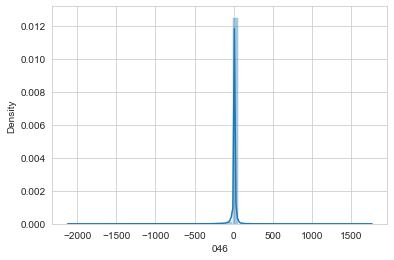

In [404]:
sns.distplot(alphas[f'{alpha:03}']);

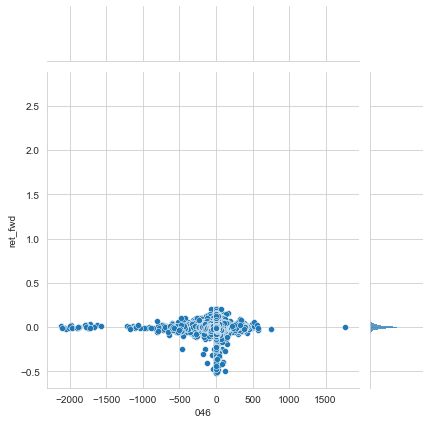

In [405]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [406]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.03994791842994605

## Alpha 047

```
rank(ts_corr(ts_lag(open - close, 1), close, 200)) + 
        rank(open - close)
```

In [407]:
def alpha047(h, c, v, vwap, adv20):
    """((((rank((1 / close)) * volume) / adv20) * ((high * rank((high - close))) / 
        (ts_sum(high, 5) /5))) - rank((vwap - ts_lag(vwap, 5))))"""

    return (rank(c.pow(-1)).mul(v).div(adv20)
            .mul(h.mul(rank(h.sub(c))
                       .div(ts_mean(h, 5)))
                 .sub(rank(ts_delta(vwap, 5))))
            .stack('code')
            .swaplevel())

In [408]:
alpha = 47

In [409]:
%%time
alphas[f'{alpha:03}'] = alpha047(h, c, v, vwap, adv20)

CPU times: total: 2.98 s
Wall time: 6.05 s


In [410]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

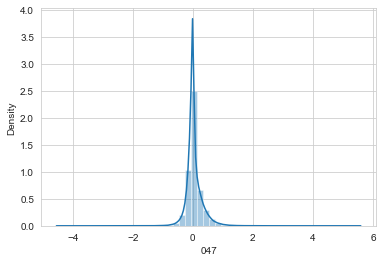

In [411]:
sns.distplot(alphas[f'{alpha:03}']);

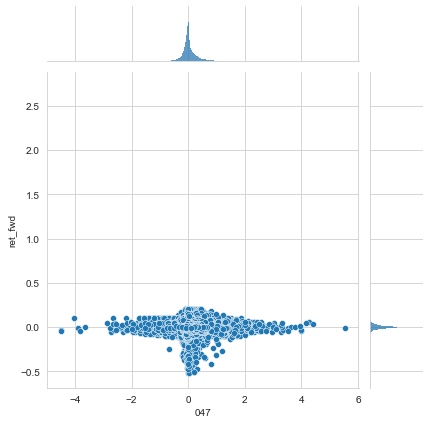

In [412]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [413]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.005947941554554248

## Alpha 048

```
(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
```

In [414]:
def alpha48(c, industry):
    """(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) * 
        ts_delta(close, 1)) / close), IndClass.subindustry) / 
        ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))"""
    pass

In [415]:
alpha = 48

In [416]:
# %%time
# alphas[f'{alpha:03}'] = alpha48(o, c)

In [417]:
# alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [418]:
# sns.distplot(alphas[f'{alpha:03}']);

In [419]:
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
# 

In [420]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 049

```
ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.1 * c
        ? 1 
        : -ts_delta(close, 1)
```

In [421]:
def alpha049(c):
    """ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.1 * c
        ? 1 
        : -ts_delta(close, 1)"""
    cond = (ts_delta(ts_lag(c, 10), 10).div(10)
            .sub(ts_delta(c, 10).div(10)) >= -0.1 * c)
    return (-ts_delta(c, 1)
            .where(cond, 1)
            .stack('code')
            .swaplevel())

In [422]:
alpha = 49

In [423]:
%%time
alphas[f'{alpha:03}'] = alpha049(c)

CPU times: total: 625 ms
Wall time: 921 ms


In [424]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

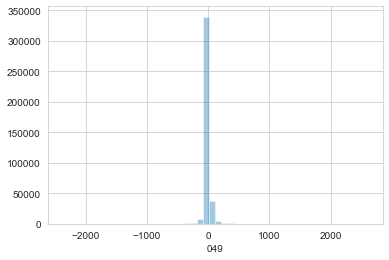

In [425]:
sns.distplot(alphas[f'{alpha:03}'], kde=False);

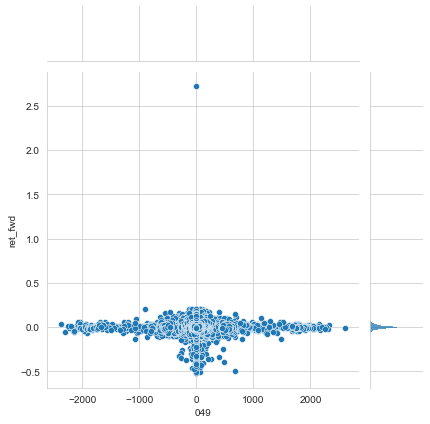

In [426]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [427]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.12249155999022143

## Alpha 050

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [428]:
def alpha050(v, vwap):
    """-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)"""
    return (ts_max(rank(ts_corr(rank(v),
                                rank(vwap), 5)), 5)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [429]:
alpha = 50

In [430]:
%%time
alphas[f'{alpha:03}'] = alpha050(v, vwap)

CPU times: total: 797 ms
Wall time: 1.98 s


In [431]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

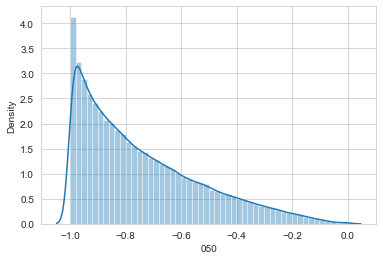

In [432]:
sns.distplot(alphas[f'{alpha:03}']);

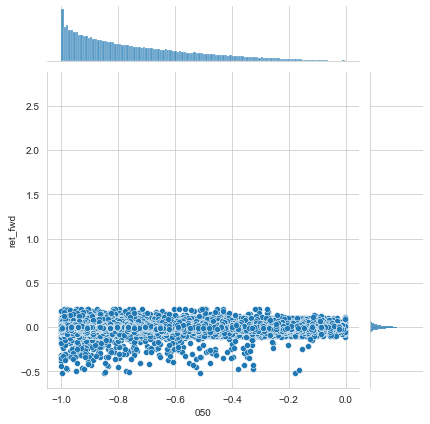

In [433]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [434]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.005856478044552915

## Alpha 051

```
ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.05 * c
        ? 1 
        : -ts_delta(close, 1)
```

In [435]:
def alpha051(c):
    """ts_delta(ts_lag(close, 10), 10).div(10).sub(ts_delta(close, 10).div(10)) < -0.05 * c
        ? 1 
        : -ts_delta(close, 1)"""
    cond = (ts_delta(ts_lag(c, 10), 10).div(10)
            .sub(ts_delta(c, 10).div(10)) >= -0.05 * c)
    return (-ts_delta(c, 1)
            .where(cond, 1)
            .stack('code')
            .swaplevel())

In [436]:
alpha = 51

In [437]:
%%time
alphas[f'{alpha:03}'] = alpha051(c)

CPU times: total: 562 ms
Wall time: 883 ms


In [438]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

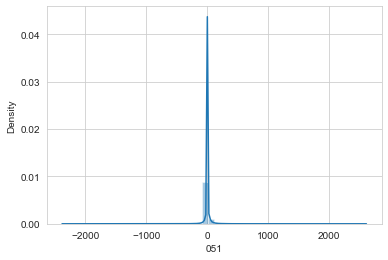

In [439]:
sns.distplot(alphas[f'{alpha:03}']);

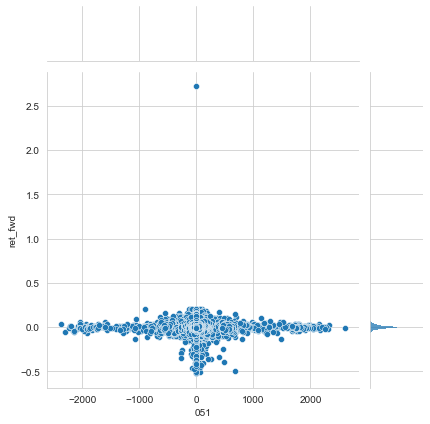

In [440]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [441]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.09516263316865503

## Alpha 052

```
(ts_lag(ts_min(low, 5), 5) - ts_min(low, 5)) * 
        rank((ts_sum(returns, 240) - ts_sum(returns, 20)) / 220) * 
        ts_rank(volume, 5)
```

In [442]:
def alpha052(l, v, r):
    """(ts_lag(ts_min(low, 5), 5) - ts_min(low, 5)) * 
        rank((ts_sum(returns, 240) - ts_sum(returns, 20)) / 220) * 
        ts_rank(volume, 5)
    """
    return (ts_delta(ts_min(l, 5), 5)
            .mul(rank(ts_sum(r, 240)
                      .sub(ts_sum(r, 20))
                      .div(220)))
            .mul(ts_rank(v, 5))
            .stack('code')
            .swaplevel())

In [443]:
alpha = 52

In [444]:
%%time
alphas[f'{alpha:03}'] = alpha052(l, v, r)

CPU times: total: 35.1 s
Wall time: 1min 32s


In [445]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

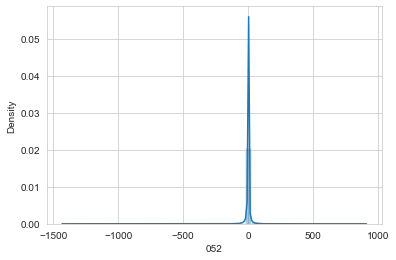

In [446]:
sns.distplot(alphas[f'{alpha:03}']);

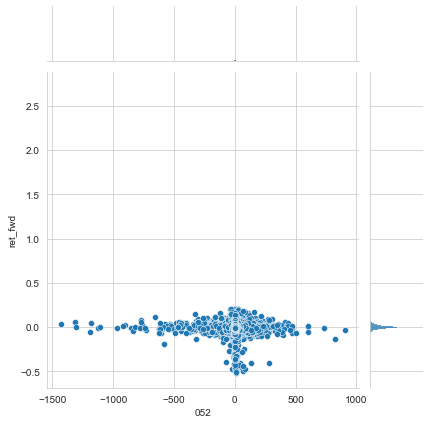

In [447]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [448]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.019786910314076422

## Alpha 053

```
((ts_sum(high, 20) / 20) < high)
            ? (-1 * ts_delta(high, 2))
            : 0
```

In [449]:
def alpha053(h, l, c):
    """-1 * ts_delta(1 - (high - close) / (close - low), 9)"""
    inner = (c.sub(l)).add(1e-6)
    return (ts_delta(h.sub(c)
                     .mul(-1).add(1)
                     .div(c.sub(l)
                          .add(1e-6)), 9)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [450]:
alpha = 53

In [451]:
%%time
alphas[f'{alpha:03}'] = alpha053(h, l, c)

CPU times: total: 8.69 s
Wall time: 15.3 s


In [452]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

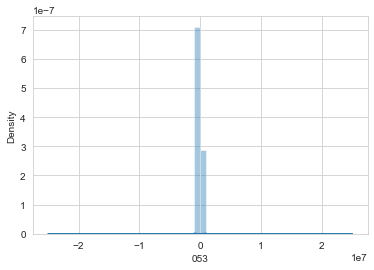

In [453]:
sns.distplot(alphas[f'{alpha:03}']);

In [454]:
alphas.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 396941 entries, ('sh.600000', Timestamp('2017-07-04 00:00:00')) to ('sz.300999', Timestamp('2023-06-20 00:00:00'))
Data columns (total 54 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   returns  396641 non-null  float64
 1   ret_fwd  396941 non-null  float64
 2   001      376065 non-null  float64
 3   002      374846 non-null  float64
 4   003      385697 non-null  float64
 5   004      388602 non-null  float64
 6   005      382992 non-null  float64
 7   006      387617 non-null  float64
 8   007      378569 non-null  float64
 9   008      385334 non-null  float64
 10  009      382725 non-null  float64
 11  010      382725 non-null  float64
 12  011      379112 non-null  float64
 13  012      382725 non-null  float64
 14  013      376065 non-null  float64
 15  014      387617 non-null  float64
 16  015      353763 non-null  float64
 17  016      392638 non-null  float64
 18  017      371186 n

In [455]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.023851979818684477

## Alpha 054

```
-(low - close) * power(open, 5) / ((low - high) * power(close, 5))
```

In [ ]:
def alpha054(o, h, l, c):
    """-(low - close) * power(open, 5) / ((low - high) * power(close, 5))"""
    return (l.sub(c).mul(o.pow(5)).mul(-1)
            .div(l.sub(h).replace(0, -0.0001).mul(c ** 5))
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 54

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha054(o, h, l, c)

CPU times: total: 15.6 ms
Wall time: 161 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

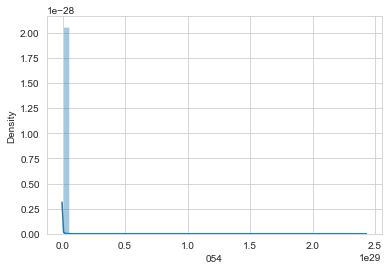

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

MemoryError: Unable to allocate 131. TiB for an array with shape (18018617249027,) and data type float64

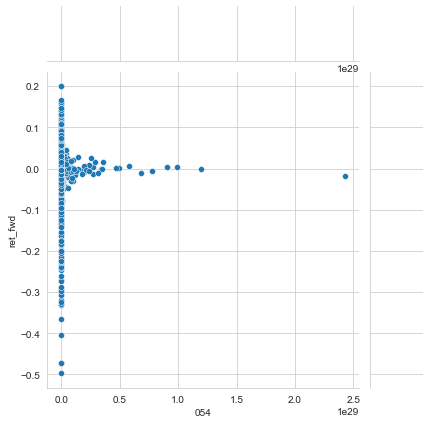

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.002305260658917785

In [ ]:
pd.Series(mi).tail()

50    0.000000
51    0.026527
52    0.011317
53    0.023852
54    0.002305
dtype: float64

## Alpha 055

```
(-1 * ts_corr(rank(((close - ts_min(low, 12)) / 
                            (ts_max(high, 12) - ts_min(low,12)))), 
                    rank(volume), 6))
```

In [ ]:
def alpha055(h, l, c):
    """(-1 * ts_corr(rank(((close - ts_min(low, 12)) / 
                            (ts_max(high, 12) - ts_min(low,12)))), 
                    rank(volume), 6))"""

    return (ts_corr(rank(c.sub(ts_min(l, 12))
                         .div(ts_max(h, 12).sub(ts_min(l, 12))
                              .replace(0, 1e-6))),
                    rank(v), 6)
            .replace([-np.inf, np.inf], np.nan)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 55

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha055(h, l, c)

CPU times: total: 188 ms
Wall time: 394 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

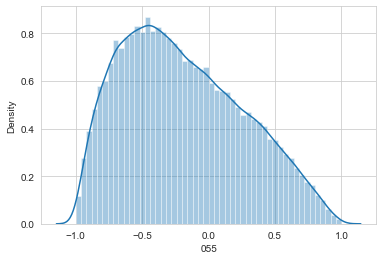

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

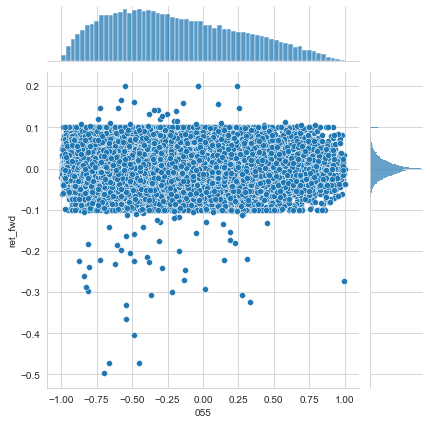

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0012642610667707999

## Alpha 056

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [ ]:
def alpha056(r, cap):
    """-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
    """
    pass

## Alpha 057

```
rank(ts_corr(ts_lag(open - close, 1), close, 200)) + 
        rank(open - close)
```

In [ ]:
def alpha057(c, vwap):
    """-(close - vwap) / ts_weighted_mean(rank(ts_argmax(close, 30)), 2)"""
    return (c.sub(vwap.add(1e-5))
            .div(ts_weighted_mean(rank(ts_argmax(c, 30)))).mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 57

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha057(c, vwap)

CPU times: total: 4.53 s
Wall time: 9.27 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

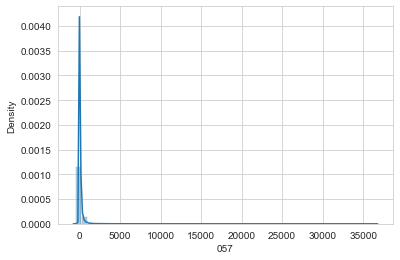

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

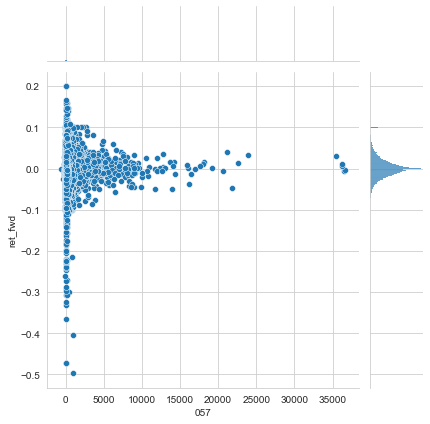

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.033017296324755474

## Alpha 058

```
(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
```

In [ ]:
def alpha58(v, wvap, sector):
    """(-1 * ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.sector), volume, 3), 7), 5))"""
    pass

## Alpha 059

```
(indneutralize(((ts_corr(ts_delta(close, 1), ts_delta(ts_lag(close, 1), 1), 250) *ts_delta(close, 1)) / close), IndClass.subindustry) / ts_sum(((ts_delta(close, 1) / ts_lag(close, 1))^2), 250))
```

In [ ]:
def alpha59(v, wvap, industry):
    """-ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), volume, 4), 16), 8)"""
    pass

## Alpha 060

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [ ]:
def alpha060(l, h, c, v):
    """-((2 * scale(rank(((((close - low) - (high - close)) / (high - low)) * volume)))) -scale(rank(ts_argmax(close, 10))))"""
    return (scale(rank(c.mul(2).sub(l).sub(h)
                       .div(h.sub(l).replace(0, 1e-5))
                       .mul(v))).mul(2)
            .sub(scale(rank(ts_argmax(c, 10)))).mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 60

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha060(l, h, c, v)

CPU times: total: 3.83 s
Wall time: 9.32 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

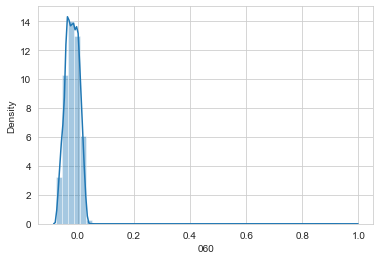

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

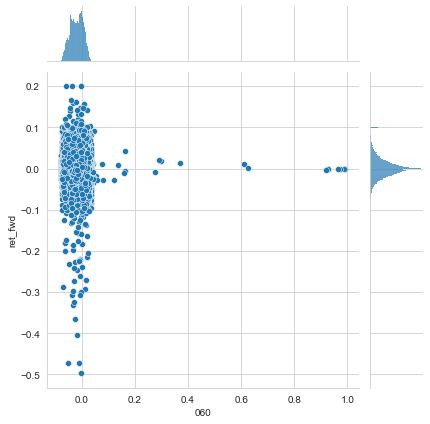

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.004589043958160843

## Alpha 061

```
(rank((vwap - ts_min(vwap, 16.1219))) < rank(ts_corr(vwap, adv180, 17.9282)))
```

In [ ]:
def alpha061(v, vwap):
    """rank((vwap - ts_min(vwap, 16))) < rank(ts_corr(vwap, adv180, 17))"""

    return (rank(vwap.sub(ts_min(vwap, 16)))
            .lt(rank(ts_corr(vwap, ts_mean(v, 180), 18)))
            .astype(int)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 61

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha061(v, vwap)

CPU times: total: 78.1 ms
Wall time: 530 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

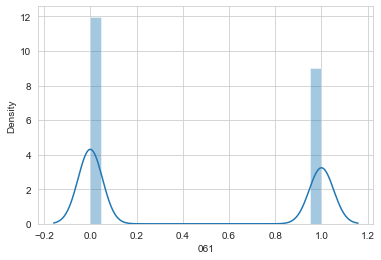

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

In [ ]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  max
061                                                                          
0    41403.0  0.001022  0.029334 -0.497644 -0.014108  0.000000  0.014714  0.2
1    31147.0  0.000427  0.026858 -0.471626 -0.013345 -0.000263  0.012384  0.2

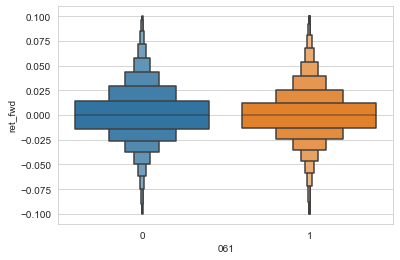

In [ ]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.1, .1)]);

## Alpha 062

```
((rank(ts_corr(vwap, ts_sum(adv20, 22.4101), 9.91009)) < rank(((rank(open) +rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)
```

In [ ]:
def alpha062(o, h, l, vwap, adv20):
    """((rank(ts_corr(vwap, ts_sum(adv20, 22.4101), 9.91009)) < 
    rank(((rank(open) + rank(open)) < (rank(((high + low) / 2)) + rank(high))))) * -1)"""
    return (rank(ts_corr(vwap, ts_sum(adv20, 22), 9))
            .lt(rank(
                rank(o).mul(2))
                .lt(rank(h.add(l).div(2))
                    .add(rank(h))))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 62

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha062(o, h, l, vwap, adv20)

CPU times: total: 484 ms
Wall time: 1.24 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

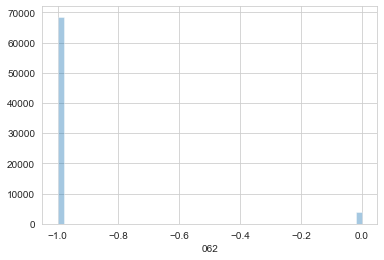

In [ ]:
sns.distplot(alphas[f'{alpha:03}'], kde=False);

In [ ]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%  50%       75%       max
062                                                                          
-1   68538.0  0.000693  0.028384 -0.497644 -0.013878  0.0  0.013698  0.200000
 0    4012.0  0.002030  0.026771 -0.329310 -0.010645  0.0  0.013168  0.100939

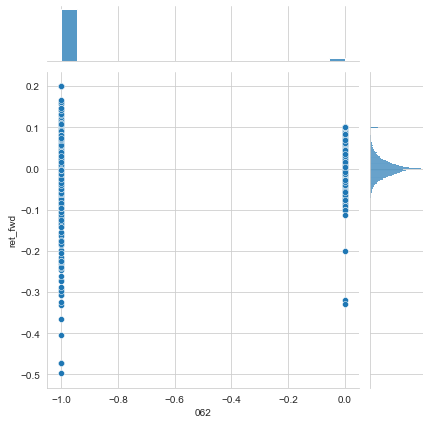

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 063

```
((rank(ts_weighted_mean(ts_delta(IndNeutralize(close, IndClass.industry), 2.25164), 8.22237))- rank(ts_weighted_mean(ts_corr(((vwap * 0.318108) + (open * (1 - 0.318108))), ts_sum(adv180,37.2467), 13.557), 12.2883))) * -1)
```

In [ ]:
def alpha63(v, wvap, industry):
    """((rank(ts_weighted_mean(ts_delta(IndNeutralize(close, IndClass.industry), 2), 8)) - 
        rank(ts_weighted_mean(ts_corr(((vwap * 0.318108) + (open * (1 - 0.318108))), 
                                        ts_sum(adv180, 37), 13), 12))) * -1)
    """
    pass

In [ ]:
alpha = 63

In [ ]:
# %%time
# alphas[f'{alpha:03}'] = alpha48(o, c)

In [ ]:
# alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [ ]:
# sns.distplot(alphas[f'{alpha:03}']);

In [ ]:
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
# 

In [ ]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 064

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [ ]:
def alpha064(o, h, l, v, vwap):
    """((rank(ts_corr(ts_sum(((open * 0.178404) + (low * (1 - 0.178404))), 12.7054),ts_sum(adv120, 12.7054), 16.6208)) <
        rank(ts_delta(((((high + low) / 2) * 0.178404) + (vwap * (1 -0.178404))), 3.69741))) * -1)"""
    w = 0.178404
    return (rank(ts_corr(ts_sum(o.mul(w).add(l.mul(1 - w)), 12),
                         ts_sum(ts_mean(v, 120), 12), 16))
            .lt(rank(ts_delta(h.add(l).div(2).mul(w)
                               .add(vwap.mul(1 - w)), 3)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 64

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha064(o, h, l, v, vwap)

CPU times: total: 31.2 ms
Wall time: 520 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [ ]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  max
064                                                                          
-1   31711.0  0.000581  0.028623 -0.497644 -0.014149 -0.000429  0.013512  0.2
 0   40839.0  0.000911  0.028044 -0.471626 -0.013443  0.000000  0.013791  0.2

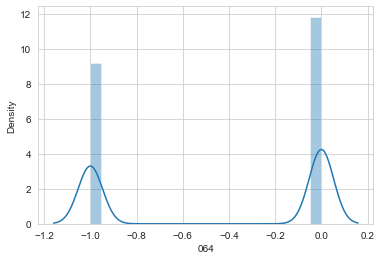

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

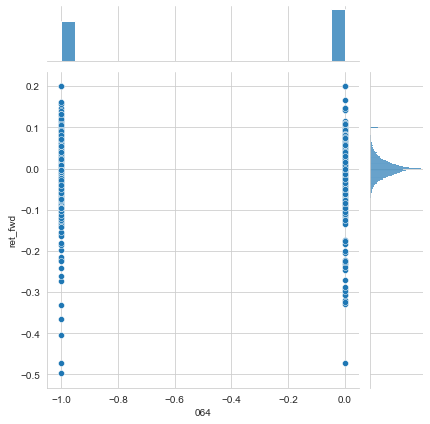

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 065

```
((rank(ts_corr(((open * 0.00817205) + (vwap * (1 - 0.00817205))), 
                        ts_sum(adv60,8.6911), 6.40374)) < 
        rank((open - ts_min(open, 13.635)))) * -1)
```

In [ ]:
def alpha065(o, v, vwap):
    """((rank(ts_corr(((open * 0.00817205) + (vwap * (1 - 0.00817205))), 
                        ts_sum(adv60,8.6911), 6.40374)) < 
        rank((open - ts_min(open, 13.635)))) * -1)
    """
    w = 0.00817205
    return (rank(ts_corr(o.mul(w).add(vwap.mul(1 - w)),
                         ts_mean(ts_mean(v, 60), 9), 6))
            .lt(rank(o.sub(ts_min(o, 13))))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 65

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha065(o, v, vwap)

CPU times: total: 78.1 ms
Wall time: 341 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

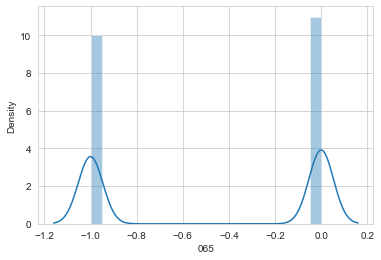

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

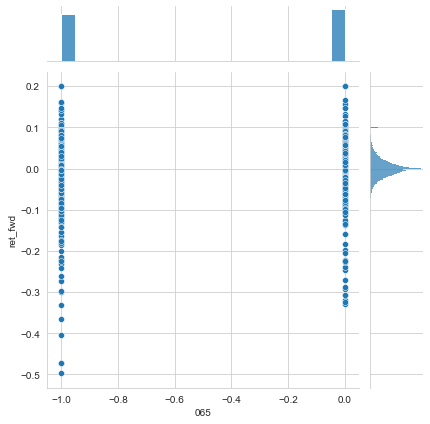

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 066

```
((rank(ts_weighted_mean(ts_delta(vwap, 3.51013), 7.23052)) + 
        ts_rank(ts_weighted_mean(((((low* 0.96633) + (low * 
                                    (1 - 0.96633))) - vwap) / 
                                    (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)
```

In [ ]:
def alpha066(l, h, vwap):
    """((rank(ts_weighted_mean(ts_delta(vwap, 3.51013), 7.23052)) +
        ts_rank(ts_weighted_mean(((((low* 0.96633) + (low *
                                    (1 - 0.96633))) - vwap) /
                                    (open - ((high + low) / 2))), 11.4157), 6.72611)) * -1)
    """
    w = 0.96633
    return (rank(ts_weighted_mean(ts_delta(vwap, 4), 7))
            .add(ts_rank(ts_weighted_mean(l.mul(w).add(l.mul(1 - w))
                                           .sub(vwap)
                                           .div(o.sub(h.add(l).div(2)).add(1e-3)), 11), 7))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 66

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha066(l, h, vwap)

CPU times: total: 5.95 s
Wall time: 14.7 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

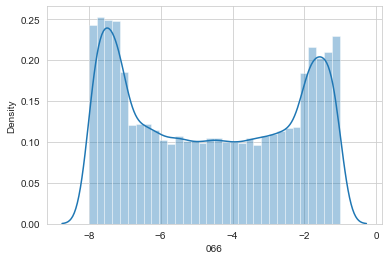

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

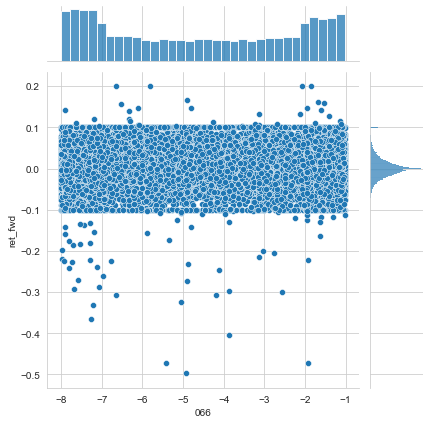

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 067

```
(rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < 
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
```

In [ ]:
def alpha067(h, v, sector, subindustry):
    """(power(rank((high - ts_min(high, 2.14593))),
        rank(ts_corr(IndNeutralize(vwap,IndClass.sector), 
                IndNeutralize(adv20, IndClass.subindustry), 6.02936))) * -1)
    """
    pass

In [ ]:
alpha = 67

In [ ]:
# %%time
# alphas[f'{alpha:03}'] = alpha056(r, cap)

In [ ]:
# alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

In [ ]:
# sns.distplot(alphas[f'{alpha:03}']);

In [ ]:
# g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);
# 

In [ ]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 068

```
((ts_rank(ts_corr(rank(high), rank(adv15), 8.91644), 13.9333) <
        rank(ts_delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)
```

In [ ]:
def alpha068(h, c, v):
    """((ts_rank(ts_corr(rank(high), rank(adv15), 8.91644), 13.9333) <
        rank(ts_delta(((close * 0.518371) + (low * (1 - 0.518371))), 1.06157))) * -1)
    """
    w = 0.518371
    return (ts_rank(ts_corr(rank(h), rank(ts_mean(v, 15)), 9), 14)
            .lt(rank(ts_delta(c.mul(w).add(l.mul(1 - w)), 1)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 68

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha068(h, c, v)

CPU times: total: 2.16 s
Wall time: 5.03 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

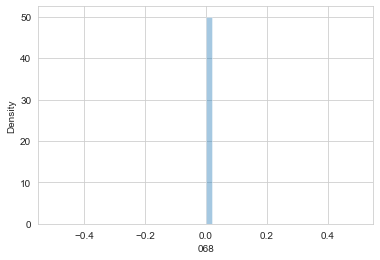

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

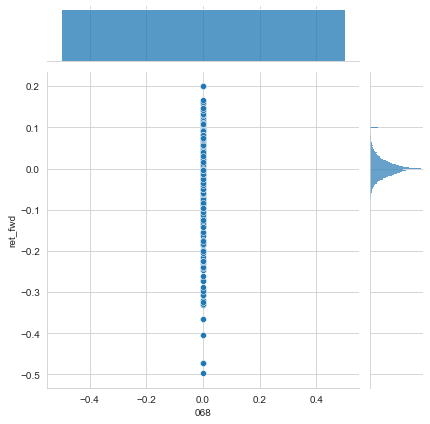

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 069

```
((power(rank(ts_max(ts_delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344)),
        Ts_Rank(ts_corr(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615))) * -1)
```

In [ ]:
def alpha069(c, vwap, industry):
    """((power(rank(ts_max(ts_delta(IndNeutralize(vwap, IndClass.industry), 2.72412),4.79344)),
    Ts_Rank(ts_corr(((close * 0.490655) + (vwap * (1 - 0.490655))), adv20, 4.92416),9.0615))) * -1)
    """
    pass

## Alpha 070

```
((power(rank(ts_delta(vwap, 1.29456)),
        ts_rank(ts_corr(IndNeutralize(close,IndClass.industry), adv50, 17.8256), 17.9171))) * -1)
```

In [ ]:
def alpha076(c, v, vwap, industry):
    """((power(rank(ts_delta(vwap, 1.29456)),
        ts_rank(ts_corr(IndNeutralize(close, IndClass.industry), adv50, 17.8256), 17.9171))) * -1)
    """
    pass

In [ ]:
alpha = 70

## Alpha 071

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [ ]:
def alpha071(o, c, v, vwap):
    """max(ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 3.43976), ts_rank(adv180,12.0647), 18.0175), 4.20501), 15.6948), 
            ts_rank(ts_weighted_mean((rank(((low + open) - (vwap +vwap)))^2), 16.4662), 4.4388))"""

    s1 = (ts_rank(ts_weighted_mean(ts_corr(ts_rank(c, 3),
                                           ts_rank(ts_mean(v, 180), 12), 18), 4), 16))
    s2 = (ts_rank(ts_weighted_mean(rank(l.add(o).
                                        sub(vwap.mul(2)))
                                   .pow(2), 16), 4))
    return (s1.where(s1 > s2, s2)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 71

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha071(o, c, v, vwap)

CPU times: total: 17.7 s
Wall time: 43.6 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

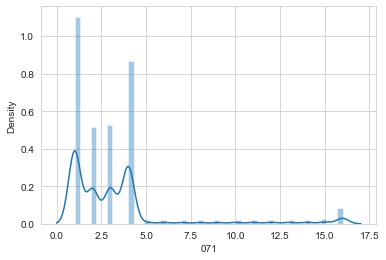

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

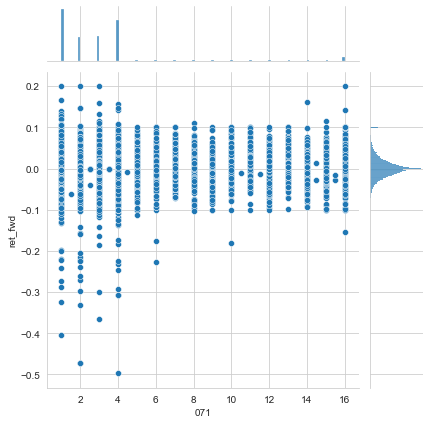

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.015466838424463614

## Alpha 072

```
(rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 8.93345), 10.1519)) /
        rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3.72469), ts_rank(volume, 18.5188), 6.86671), 2.95011)))
```

In [ ]:
def alpha072(h, l, v, vwap):
    """(rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 8.93345), 10.1519)) /
        rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3.72469), ts_rank(volume, 18.5188), 6.86671), 2.95011)))
    """
    return (rank(ts_weighted_mean(ts_corr(h.add(l).div(2), ts_mean(v, 40), 9), 10))
            .div(rank(ts_weighted_mean(ts_corr(ts_rank(vwap, 3), ts_rank(v, 18), 6), 2)))
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 72

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha072(h, l, v, vwap)

CPU times: total: 14.1 s
Wall time: 28.8 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

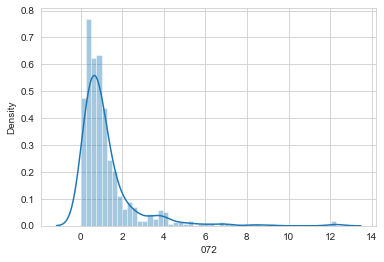

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

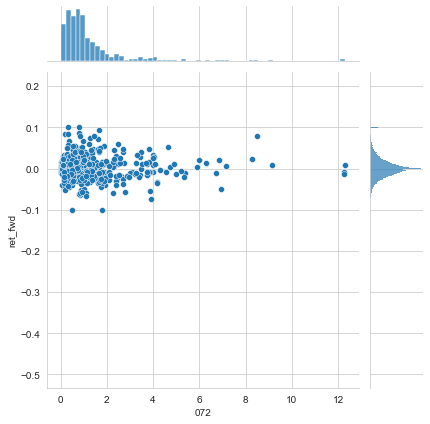

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


## Alpha 073

```
(max(rank(ts_weighted_mean(ts_delta(vwap, 4.72775), 2.91864)),
        ts_rank(ts_weighted_mean(((ts_delta(((open * 0.147155) + 
            (low * (1 - 0.147155))), 2.03608) / 
            ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)
```

In [ ]:
def alpha073(l, vwap):
    """(max(rank(ts_weighted_mean(ts_delta(vwap, 4.72775), 2.91864)),
        ts_rank(ts_weighted_mean(((ts_delta(((open * 0.147155) + 
            (low * (1 - 0.147155))), 2.03608) / 
            ((open *0.147155) + (low * (1 - 0.147155)))) * -1), 3.33829), 16.7411)) * -1)
        """
    w = 0.147155
    s1 = rank(ts_weighted_mean(ts_delta(vwap, 5), 3))
    s2 = (ts_rank(ts_weighted_mean(ts_delta(o.mul(w).add(l.mul(1 - w)), 2)
                                   .div(o.mul(w).add(l.mul(1 - w)).mul(-1)), 3), 16))

    print(s2)
    return (s1.where(s1 > s2, s2)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 73

In [ ]:
# %%time
alphas[f'{alpha:03}'] = alpha073(l, vwap)

code        sh.600030  sh.600031  sh.600036  sh.600048  sh.600111  sh.600196  \
date                                                                           
2017-07-04        NaN        NaN        NaN        NaN        NaN        NaN   
2017-07-05        NaN        NaN        NaN        NaN        NaN        NaN   
2017-07-06        NaN        NaN        NaN        NaN        NaN        NaN   
2017-07-07        NaN        NaN        NaN        NaN        NaN        NaN   
2017-07-10        NaN        NaN        NaN        NaN        NaN        NaN   
...               ...        ...        ...        ...        ...        ...   
2023-06-14        5.0        5.0       10.0        6.0        4.0        2.0   
2023-06-15        2.0        1.0       11.0        7.0        7.0        2.0   
2023-06-16        1.0        1.0        7.0        8.0        4.0        2.0   
2023-06-19        2.0        2.0        7.0        9.0        4.0        1.0   
2023-06-20        9.0        6.0       1

In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

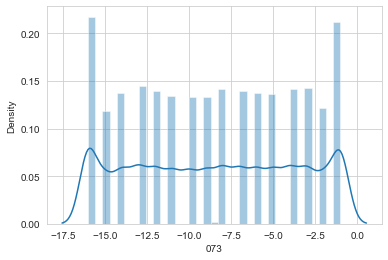

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

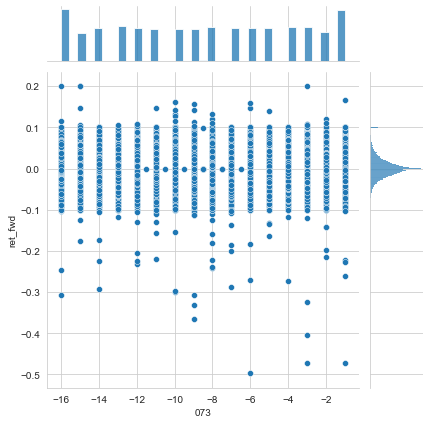

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.016474247531953257

## Alpha 074

```
((rank(ts_corr(close, ts_sum(adv30, 37.4843), 15.1365)) <
        rank(ts_corr(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1)
```

In [ ]:
def alpha074(v, vwap):
    """((rank(ts_corr(close, ts_sum(adv30, 37.4843), 15.1365)) <
        rank(ts_corr(rank(((high * 0.0261661) + (vwap * (1 - 0.0261661)))), rank(volume), 11.4791)))* -1)"""

    w = 0.0261661
    return (rank(ts_corr(c, ts_mean(ts_mean(v, 30), 37), 15))
            .lt(rank(ts_corr(rank(h.mul(w).add(vwap.mul(1 - w))), rank(v), 11)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 74

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha074(v, vwap)

CPU times: total: 156 ms
Wall time: 511 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

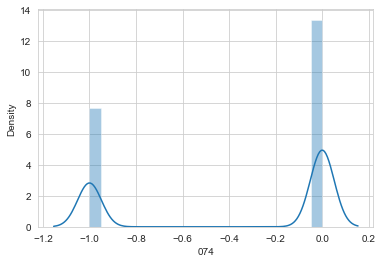

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

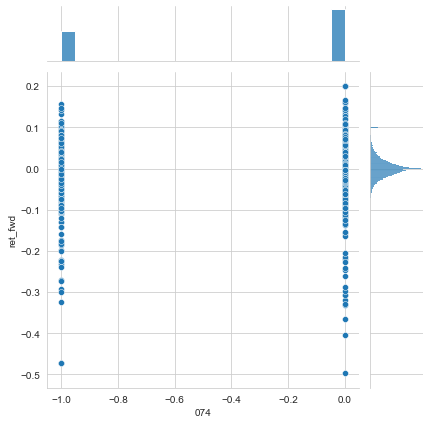

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%  50%       75%       max
074                                                                          
-1   26390.0  0.000727  0.029515 -0.473149 -0.014493  0.0  0.014519  0.155919
 0   46160.0  0.000790  0.027580 -0.497644 -0.013359  0.0  0.013240  0.200000

## Alpha 075

```
(rank(ts_corr(vwap, volume, 4.24304)) < 
        rank(ts_corr(rank(low), rank(adv50),12.4413)))
```

In [ ]:
def alpha075(l, v, vwap):
    """(rank(ts_corr(vwap, volume, 4.24304)) < 
        rank(ts_corr(rank(low), rank(adv50),12.4413)))
    """

    return (rank(ts_corr(vwap, v, 4))
            .lt(rank(ts_corr(rank(l), rank(ts_mean(v, 50)), 12)))
            .astype(int)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 75

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha075(l, v, vwap)

CPU times: total: 219 ms
Wall time: 510 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

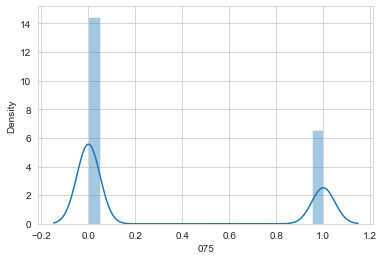

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

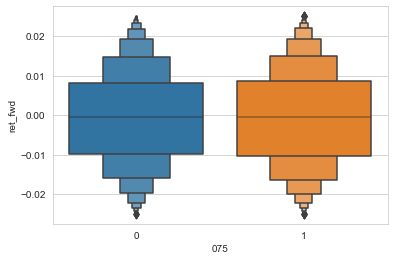

In [ ]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.025, .025)]);

In [ ]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%  50%       75%       max
075                                                                          
0    49957.0  0.000739  0.027914 -0.497644 -0.013416  0.0  0.013343  0.199969
1    22593.0  0.000828  0.029132 -0.473149 -0.014474  0.0  0.014519  0.200000

## Alpha 076

```
(rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < 
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
```

In [ ]:
def alpha076(l, vwap, sector):
    """(max(rank(ts_weighted_mean(ts_delta(vwap, 1.24383), 11.8259)),
            ts_rank(ts_weighted_mean(ts_rank(ts_corr(IndNeutralize(low, IndClass.sector), adv81,8.14941), 19.569), 17.1543), 19.383)) * -1)
    """
    pass

In [ ]:
alpha = 76

## Alpha 077

```
min(rank(ts_weighted_mean(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),
            rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 3.1614), 5.64125)))
```

In [ ]:
def alpha077(l, h, vwap):
    """min(rank(ts_weighted_mean(((((high + low) / 2) + high) - (vwap + high)), 20.0451)),
            rank(ts_weighted_mean(ts_corr(((high + low) / 2), adv40, 3.1614), 5.64125)))
    """

    s1 = rank(ts_weighted_mean(h.add(l).div(2).sub(vwap), 20))
    s2 = rank(ts_weighted_mean(ts_corr(h.add(l).div(2), ts_mean(v, 40), 3), 5))
    return (s1.where(s1 < s2, s2)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 77

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha077(l, h, vwap)

CPU times: total: 125 ms
Wall time: 351 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

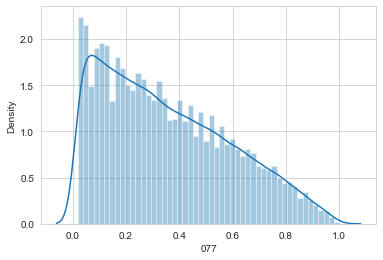

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

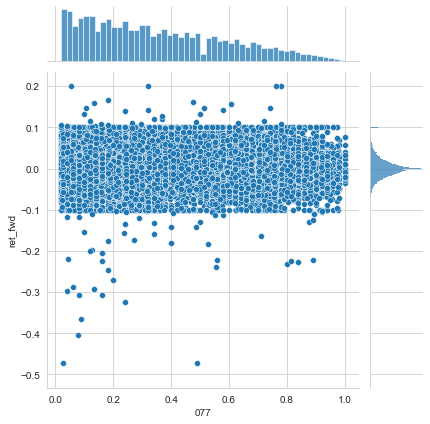

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 078

```
(rank(ts_corr(ts_sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),
        ts_sum(adv40, 19.7428), 6.83313))^rank(ts_corr(rank(vwap), rank(volume), 5.77492)))
```

In [ ]:
def alpha078(l, v, vwap):
    """(rank(ts_corr(ts_sum(((low * 0.352233) + (vwap * (1 - 0.352233))), 19.7428),
        ts_sum(adv40, 19.7428), 6.83313))^rank(ts_corr(rank(vwap), rank(volume), 5.77492)))"""

    w = 0.352233
    return (rank(ts_corr(ts_sum((l.mul(w).add(vwap.mul(1 - w))), 19),
                         ts_sum(ts_mean(v, 40), 19), 6))
            .pow(rank(ts_corr(rank(vwap), rank(v), 5)))
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 78

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha078(l, v, vwap)

CPU times: total: 109 ms
Wall time: 508 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

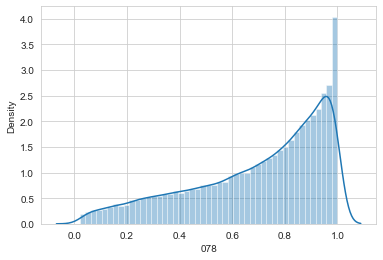

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

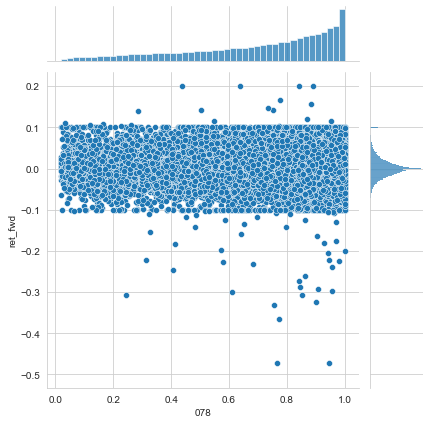

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 079

```
(rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < 
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
```

In [ ]:
def alpha079(o, v, sector):
    """(rank(ts_delta(IndNeutralize(((close * 0.60733) + (open * (1 - 0.60733))),IndClass.sector), 1.23438)) < 
        rank(ts_corr(Ts_Rank(vwap, 3.60973), Ts_Rank(adv150,9.18637), 14.6644)))
    """
    pass

## Alpha 080

```
((power(rank(sign(ts_delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545))),
        ts_rank(ts_corr(high, adv10, 5.11456), 5.53756)) * -1)
```

In [ ]:
def alpha080(h, industry):
    """((power(rank(sign(ts_delta(IndNeutralize(((open * 0.868128) + (high * (1 - 0.868128))),IndClass.industry), 4.04545))),
        ts_rank(ts_corr(high, adv10, 5.11456), 5.53756)) * -1)
    """
    pass

## Alpha 081

```
-(rank(log(ts_product(rank((rank(ts_corr(vwap, ts_sum(adv10, 49.6054),8.47743))^4)), 14.9655))) <
        rank(ts_corr(rank(vwap), rank(volume), 5.07914)))
```

In [ ]:
def alpha081(v, vwap):
    """-(rank(log(ts_product(rank((rank(ts_corr(vwap, ts_sum(adv10, 49.6054),8.47743))^4)), 14.9655))) <
        rank(ts_corr(rank(vwap), rank(volume), 5.07914)))"""

    return (rank(log(ts_product(rank(rank(ts_corr(vwap,
                                                  ts_sum(ts_mean(v, 10), 50), 8))
                                     .pow(4)), 15)))
            .lt(rank(ts_corr(rank(vwap), rank(v), 5)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 81

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha081(v, vwap)

CPU times: total: 3.72 s
Wall time: 9.31 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

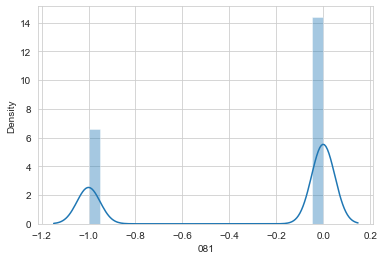

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

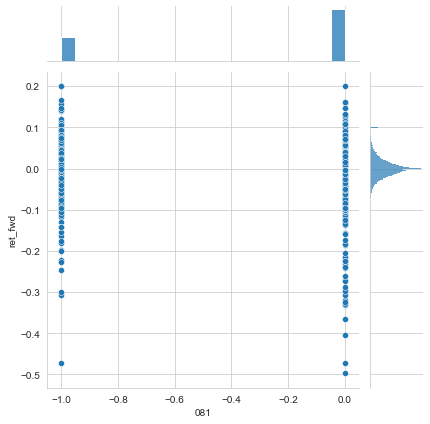

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
# mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
# mi[alpha]

## Alpha 082

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [ ]:
def alpha082(o, v, sector):
    """(min(rank(ts_weighted_mean(ts_delta(open, 1.46063), 14.8717)),
        ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(volume, IndClass.sector), 
        ((open * 0.634196) +(open * (1 - 0.634196))), 17.4842), 6.92131), 13.4283)) * -1)
    
    """
    pass

## Alpha 083

```
(rank(ts_lag((high - low) / ts_mean(close, 5), 2)) * rank(rank(volume)) / 
    (((high - low) / ts_mean(close, 5) / (vwap - close)))
```

In [ ]:
def alpha083(h, l, c):
    """(rank(ts_lag((high - low) / ts_mean(close, 5), 2)) * rank(rank(volume)) / 
            (((high - low) / ts_mean(close, 5) / (vwap - close)))
    """
    s = h.sub(l).div(ts_mean(c, 5))

    return (rank(rank(ts_lag(s, 2))
                 .mul(rank(rank(v)))
                 .div(s).div(vwap.sub(c).add(1e-3)))
            .stack('code')
            .swaplevel()
            .replace((np.inf, -np.inf), np.nan))

In [ ]:
alpha = 83

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha083(h, l, c)

CPU times: total: 93.8 ms
Wall time: 177 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

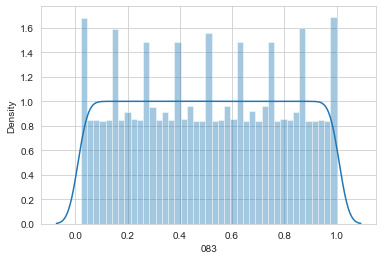

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

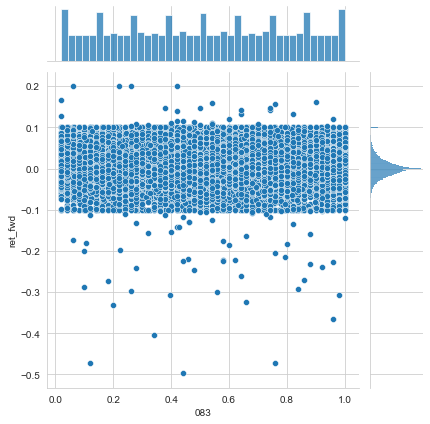

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.011201904258746787

## Alpha 084

```
power(ts_rank((vwap - ts_max(vwap, 15.3217)), 20.7127), 
            ts_delta(close,4.96796))
```

In [ ]:
def alpha084(c, vwap):
    """power(ts_rank((vwap - ts_max(vwap, 15.3217)), 20.7127), 
        ts_delta(close,4.96796))"""
    return (rank(power(ts_rank(vwap.sub(ts_max(vwap, 15)), 20),
                       ts_delta(c, 6)))
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 84

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha084(c, vwap)

CPU times: total: 6.25 s
Wall time: 14.6 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

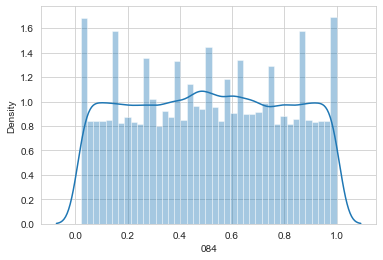

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

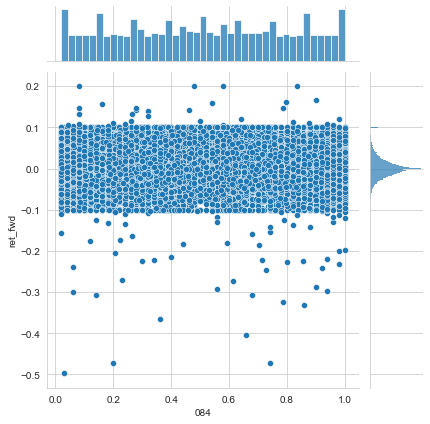

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0069533903231651095

## Alpha 085

```
power(rank(ts_corr(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331)),
        rank(ts_corr(ts_rank(((high + low) / 2), 3.70596), 
                     ts_rank(volume, 10.1595),7.11408)))
```

In [ ]:
def alpha085(l, v):
    """power(rank(ts_corr(((high * 0.876703) + (close * (1 - 0.876703))), adv30,9.61331)),
        rank(ts_corr(ts_rank(((high + low) / 2), 3.70596), 
                     ts_rank(volume, 10.1595),7.11408)))
                     """
    w = 0.876703
    return (rank(ts_corr(h.mul(w).add(c.mul(1 - w)), ts_mean(v, 30), 10))
            .pow(rank(ts_corr(ts_rank(h.add(l).div(2), 4),
                              ts_rank(v, 10), 7)))
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 85

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha085(l, v)

CPU times: total: 12.8 s
Wall time: 29.2 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

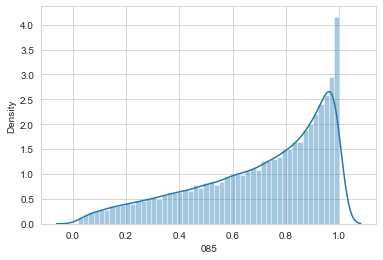

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

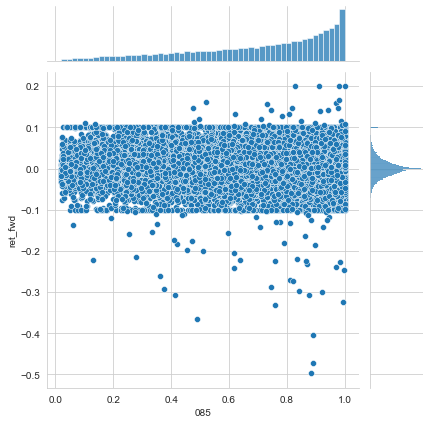

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.018757010762585402

## Alpha 086

```
((ts_rank(ts_corr(close, ts_sum(adv20, 14.7444), 6.00049), 20.4195) < 
        rank(((open + close) - (vwap + open)))) * -1)
```

In [ ]:
def alpha086(c, v, vwap):
    """((ts_rank(ts_corr(close, ts_sum(adv20, 14.7444), 6.00049), 20.4195) < 
        rank(((open + close) - (vwap + open)))) * -1)
    """
    return (ts_rank(ts_corr(c, ts_mean(ts_mean(v, 20), 15), 6), 20)
            .lt(rank(c.sub(vwap)))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 86

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha086(c, v, vwap)

CPU times: total: 6.53 s
Wall time: 14.1 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

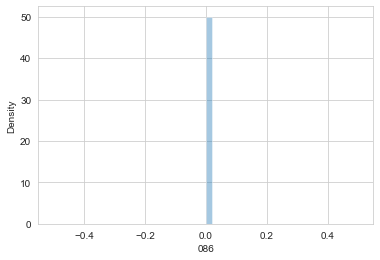

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

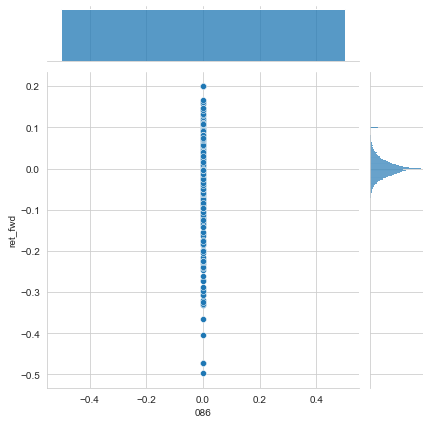

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 087

```
(max(rank(ts_weighted_mean(ts_delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), 
            ts_rank(ts_weighted_mean(abs(ts_corr(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)
            ```

In [ ]:
def alpha087(c, vwap, industry):
    """(max(rank(ts_weighted_mean(ts_delta(((close * 0.369701) + (vwap * (1 - 0.369701))),1.91233), 2.65461)), 
            ts_rank(ts_weighted_mean(abs(ts_corr(IndNeutralize(adv81,IndClass.industry), close, 13.4132)), 4.89768), 14.4535)) * -1)
    """
    pass

## Alpha 088

```
min(rank(ts_weighted_mean(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)), 
        ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 8.44728), 
                ts_rank(adv60,20.6966), 8.01266), 6.65053), 2.61957))
```

In [ ]:
def alpha088(o, h, l, c, v):
    """min(rank(ts_weighted_mean(((rank(open) + rank(low)) - (rank(high) + rank(close))),8.06882)), 
        ts_rank(ts_weighted_mean(ts_corr(ts_rank(close, 8.44728), 
                ts_rank(adv60,20.6966), 8.01266), 6.65053), 2.61957))"""

    s1 = (rank(ts_weighted_mean(rank(o)
                                .add(rank(l))
                                .sub(rank(h))
                                .add(rank(c)), 8)))
    s2 = ts_rank(ts_weighted_mean(ts_corr(ts_rank(c, 8),
                                          ts_rank(ts_mean(v, 60), 20), 8), 6), 2)

    return (s1.where(s1 < s2, s2)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 88

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha088(o, h, l, c, v)

CPU times: total: 13.4 s
Wall time: 28.4 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

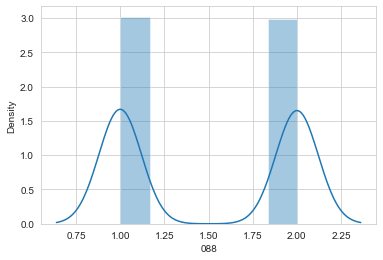

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

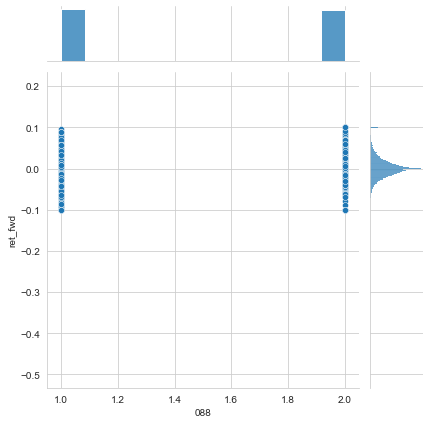

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'], n=1000)
mi[alpha]

0

## Alpha 089

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [ ]:
def alpha089(l, v, vwap, industry):
    """(ts_rank(ts_weighted_mean(ts_corr(((low * 0.967285) + 
        (low * (1 - 0.967285))), adv10,6.94279), 5.51607), 3.79744) - 
        ts_rank(ts_weighted_mean(ts_delta(IndNeutralize(vwap,IndClass.industry), 3.48158), 10.1466), 15.3012))
    """
    pass

## Alpha 090

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [ ]:
def alpha090(c, l, subindustry):
    """((rank((close - ts_max(close, 4.66719)))
        ^ts_rank(ts_corr(IndNeutralize(adv40,IndClass.subindustry), low, 5.38375), 3.21856)) * -1)
    """
    pass

## Alpha 091

```
((ts_rank(ts_weighted_mean(ts_weighted_mean(ts_corr(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -
        rank(ts_weighted_mean(ts_corr(vwap, adv30, 4.01303), 2.6809))) * -1)
```

In [ ]:
def alpha091(v, vwap, industry):
    """((ts_rank(ts_weighted_mean(ts_weighted_mean(ts_corr(IndNeutralize(close,IndClass.industry), volume, 9.74928), 16.398), 3.83219), 4.8667) -
        rank(ts_weighted_mean(ts_corr(vwap, adv30, 4.01303), 2.6809))) * -1)
    """
    pass

## Alpha 092

```
min(ts_rank(ts_weighted_mean(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683), 
            ts_rank(ts_weighted_mean(ts_corr(rank(low), rank(adv30), 7.58555), 6.94024),6.80584))
```

In [ ]:
def alpha092(o, l, c, v):
    """min(ts_rank(ts_weighted_mean(((((high + low) / 2) + close) < (low + open)), 14.7221),18.8683), 
            ts_rank(ts_weighted_mean(ts_corr(rank(low), rank(adv30), 7.58555), 6.94024),6.80584))
    """
    p1 = ts_rank(ts_weighted_mean(h.add(l).div(2).add(c).lt(l.add(o)), 15), 18)
    p2 = ts_rank(ts_weighted_mean(ts_corr(rank(l), rank(ts_mean(v, 30)), 7), 6), 6)

    return (p1.where(p1<p2, p2)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 92

In [ ]:
v

code          sh.600030    sh.600031   sh.600036    sh.600048    sh.600111  \
date                                                                         
2017-07-04   72789645.0   68396738.0  57363680.0   69320875.0   21784313.0   
2017-07-05   59509848.0   59675173.0  78399696.0   59513921.0   28695504.0   
2017-07-06   86394887.0   84750800.0  62433300.0   52668592.0   68485477.0   
2017-07-07   89463500.0   57766879.0  63217985.0  108004216.0  176990206.0   
2017-07-10  110150632.0  134808211.0  37203437.0  138266634.0  152608579.0   
...                 ...          ...         ...          ...          ...   
2023-06-14   75619125.0  121221850.0  38263310.0   60599712.0   14939014.0   
2023-06-15   83087922.0  140570505.0  36953706.0   49481041.0   32768357.0   
2023-06-16   70242566.0  139768918.0  42680637.0   58442413.0   20988232.0   
2023-06-19   67958305.0   85836432.0  27896062.0   61914903.0   19751643.0   
2023-06-20   60137878.0   58802829.0  30764875.0   71800461.0   18908447.0   

code         sh.600196   sh.600276   sh.600309   sh.600438  sh.600519  ...  \
date                                                                   ...   
2017-07-04  14023102.0  10119631.0  37458450.0  19450796.0  5648895.0  ...   
2017-07-05   8609442.0   4521563.0  44000797.0  12334995.0  3754032.0  ...   
2017-07-06  55380864.0   6406945.0  39300285.0  10123833.0  4204439.0  ...   
2017-07-07  22597122.0   6717756.0  38960656.0  16080334.0  3779647.0  ...   
2017-07-10  24960344.0   6860452.0  40056076.0  12767736.0  3662409.0  ...   
...                ...         ...         ...         ...        ...  ...   
2023-06-14   9912328.0  41155584.0  10475853.0  25401628.0  3150580.0  ...   
2023-06-15  12969977.0  31730099.0   7384569.0  70750621.0  2522257.0  ...   
2023-06-16   9891528.0  38034366.0   7767260.0  66918021.0  3791789.0  ...   
2023-06-19  22199311.0  21812681.0   7807234.0  35780972.0  3169992.0  ...   
2023-06-20  11310083.0  14896722.0   8665400.0  30830980.0  2094674.0  ...   

code         sz.002415   sz.002460   sz.002466    sz.002475   sz.002594  \
date                                                                      
2017-07-04  89711550.0  38292525.0  33866710.0   12122876.0   4946945.0   
2017-07-05  56480799.0  48562622.0  43139430.0    9725618.0   5198184.0   
2017-07-06  56515225.0  53934001.0  47403423.0   12779049.0   5756060.0   
2017-07-07  41831731.0  39813116.0  29603391.0   15235032.0   3292456.0   
2017-07-10  54122219.0  32305368.0  24621821.0    8883984.0   3805700.0   
...                ...         ...         ...          ...         ...   
2023-06-14  46229683.0  13488089.0  23819095.0   69816936.0  12577600.0   
2023-06-15  36967962.0  26922411.0  47773281.0   48026379.0  24396107.0   
2023-06-16  62582202.0  17643851.0  32334799.0  118649259.0  15229682.0   
2023-06-19  70493707.0  15698788.0  30823740.0   78032600.0  12356475.0   
2023-06-20  50590314.0  12356094.0  21284405.0  226956843.0  10236616.0   

code         sz.002714    sz.300014    sz.300059   sz.300122   sz.300274  
date                                                                      
2017-07-04   9788320.0   70359012.0   56173616.0   8371784.0   8423736.0  
2017-07-05   5696011.0   62170057.0   68318241.0   6398467.0   8506919.0  
2017-07-06   9075996.0  115400916.0   63724107.0   5446598.0  13423504.0  
2017-07-07   8257122.0  105806734.0   50798837.0   6257575.0   8803818.0  
2017-07-10  19647162.0   77008461.0   63954992.0   8678469.0  10987148.0  
...                ...          ...          ...         ...         ...  
2023-06-14  11352650.0   33403399.0  243237170.0   6291192.0  18273918.0  
2023-06-15  20485450.0   55634796.0  393111999.0  12670382.0  38679861.0  
2023-06-16  30679477.0   33034150.0  339475285.0  17142514.0  31711869.0  
2023-06-19  25907833.0   20714003.0  260470050.0  11485385.0  16183960.0  
2023-06-20  15724969.0   28516962.0  233280022.0   8734585.0  14168712.0  

[1451 rows x 50 co

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha092(o, l, c, v)

Exception: inputs are all NaN

In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

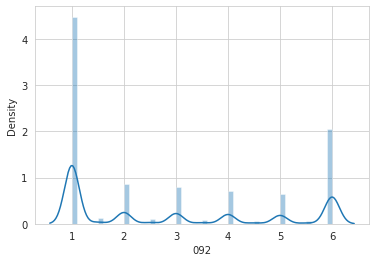

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

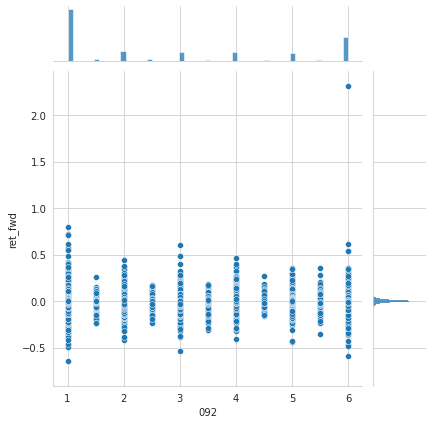

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.0034230030791526644

## Alpha 093

```
(ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / 
        rank(ts_weighted_mean(ts_delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
```

In [ ]:
def alpha093(c, v, vwap, industry):
    """(ts_rank(ts_weighted_mean(ts_corr(IndNeutralize(vwap, IndClass.industry), adv81,17.4193), 19.848), 7.54455) / 
        rank(ts_weighted_mean(ts_delta(((close * 0.524434) + (vwap * (1 -0.524434))), 2.77377), 16.2664)))
    """
    pass

## Alpha 094

```
((rank((vwap - ts_min(vwap, 11.5783)))^ts_rank(ts_corr(ts_rank(vwap,19.6462), 
        ts_rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)
```

In [ ]:
def alpha094(v, vwap):
    """((rank((vwap - ts_min(vwap, 11.5783)))^ts_rank(ts_corr(ts_rank(vwap,19.6462), 
        ts_rank(adv60, 4.02992), 18.0926), 2.70756)) * -1)
    """

    return (rank(vwap.sub(ts_min(vwap, 11)))
            .pow(ts_rank(ts_corr(ts_rank(vwap, 20),
                                 ts_rank(ts_mean(v, 60), 4), 18), 2))
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 94

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha094(v, vwap)

CPU times: total: 17.6 s
Wall time: 40.7 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

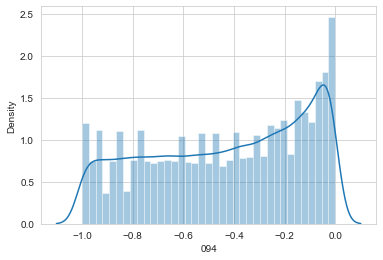

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

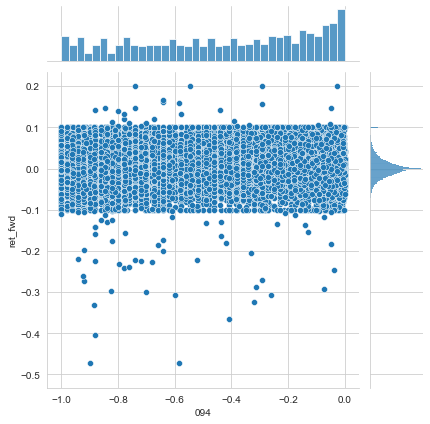

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.008694114775908979

## Alpha 095

```
(rank((open - ts_min(open, 12.4105))) < 
    ts_rank((rank(ts_corr(ts_sum(((high + low)/ 2), 19.1351), 
    ts_sum(adv40, 19.1351), 12.8742))^5), 11.7584))
```

In [ ]:
def alpha095(o, l, v):
    """(rank((open - ts_min(open, 12.4105))) < 
        ts_rank((rank(ts_corr(ts_sum(((high + low)/ 2), 19.1351), ts_sum(adv40, 19.1351), 12.8742))^5), 11.7584))
    """
    
    return (rank(o.sub(ts_min(o, 12)))
            .lt(ts_rank(rank(ts_corr(ts_mean(h.add(l).div(2), 19),
                                     ts_sum(ts_mean(v, 40), 19), 13).pow(5)), 12))
            .astype(int)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 95

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha095(o, l, v)

CPU times: total: 5.75 s
Wall time: 14.3 s


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

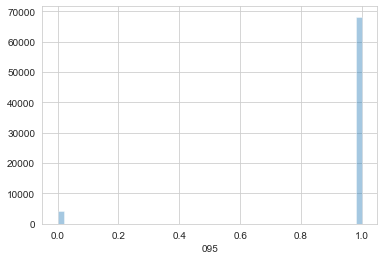

In [ ]:
sns.distplot(alphas[f'{alpha:03}'], kde=False);

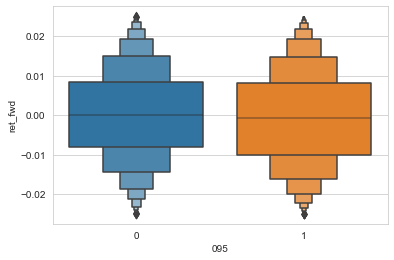

In [ ]:
g = sns.boxenplot(x=f'{alpha:03}', y='ret_fwd', data=alphas[alphas.ret_fwd.between(-.025, .025)]);

In [ ]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%       50%       75%  \
095                                                                        
0     4366.0  0.003171  0.025088 -0.329310 -0.009696  0.000521  0.013916   
1    68184.0  0.000613  0.028485 -0.497644 -0.014002  0.000000  0.013651   

          max  
095            
0    0.100619  
1    0.200000

## Alpha 096

```
(max(ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(volume), 5.83878),4.16783), 8.38151), 
        ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(close, 7.45404), ts_rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)
```

In [ ]:
def alpha096(c, v, vwap):
    """(max(ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(volume), 5.83878),4.16783), 8.38151), 
        ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(close, 7.45404), ts_rank(adv60, 4.13242), 3.65459), 12.6556), 14.0365), 13.4143)) * -1)"""
    
    s1 = ts_rank(ts_weighted_mean(ts_corr(rank(vwap), rank(v), 10), 4), 8)
    s2 = ts_rank(ts_weighted_mean(ts_argmax(ts_corr(ts_rank(c, 7),
                                                    ts_rank(ts_mean(v, 60), 10), 10), 12), 14), 13)
    return (s1.where(s1 > s2, s2)
            .mul(-1)
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 96

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha096(c, v, vwap)

Exception: inputs are all NaN

In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

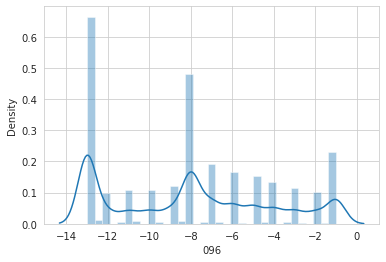

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

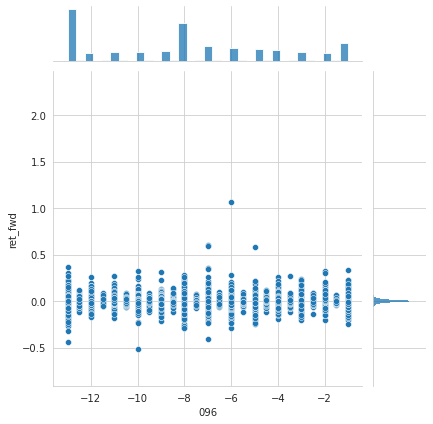

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas)


## Alpha 097

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [ ]:
def alpha097(l):
    """((rank(ts_weighted_mean(ts_delta(IndNeutralize(((low * 0.721001) + 
        (vwap * (1 - 0.721001))),IndClass.industry), 3.3705), 20.4523)) - 
        ts_rank(ts_weighted_mean(ts_rank(ts_corr(Ts_Rank(low,7.87871), 
        ts_rank(adv60, 17.255), 4.97547), 18.5925), 15.7152), 6.71659)) * -1)
    """
    pass

## Alpha 098

```
(rank(ts_weighted_mean(ts_corr(vwap, ts_sum(adv5, 26.4719), 4.58418), 7.18088)) -
        rank(ts_weighted_mean(ts_tank(ts_argmin(ts_corr(rank(open), 
        rank(adv15), 20.8187), 8.62571),6.95668), 8.07206)))
```

In [ ]:
def alpha098(o, v, vwap):
    """(rank(ts_weighted_mean(ts_corr(vwap, ts_sum(adv5, 26.4719), 4.58418), 7.18088)) -
        rank(ts_weighted_mean(ts_tank(ts_argmin(ts_corr(rank(open), 
        rank(adv15), 20.8187), 8.62571),6.95668), 8.07206)))
    """
    adv5 = ts_mean(v, 5)
    adv15 = ts_mean(v, 15)
    return (rank(ts_weighted_mean(ts_corr(vwap, ts_mean(adv5, 26), 4), 7))
            .sub(rank(ts_weighted_mean(ts_rank(ts_argmin(ts_corr(rank(o),
                                                                 rank(adv15), 20), 8), 6))))
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 98

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha098(o, v, vwap)

Exception: inputs are all NaN

In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

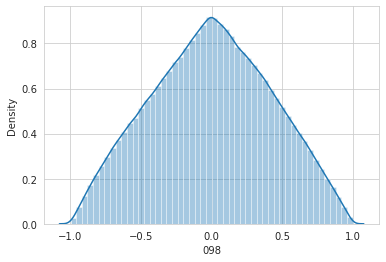

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

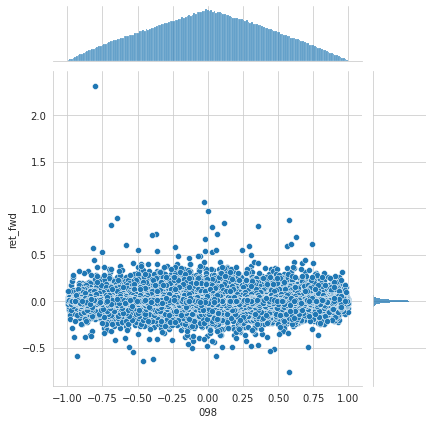

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0

## Alpha 099

```
((rank(ts_corr(ts_sum(((high + low) / 2), 19.8975), 
                    ts_sum(adv60, 19.8975), 8.8136)) <
                    rank(ts_corr(low, volume, 6.28259))) * -1)
```

In [ ]:
def alpha099(l, v):
    """((rank(ts_corr(ts_sum(((high + low) / 2), 19.8975), 
                    ts_sum(adv60, 19.8975), 8.8136)) <
                    rank(ts_corr(low, volume, 6.28259))) * -1)"""

    return ((rank(ts_corr(ts_sum((h.add(l).div(2)), 19),
                          ts_sum(ts_mean(v, 60), 19), 8))
             .lt(rank(ts_corr(l, v, 6)))
             .mul(-1))
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 99

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha099(l, v)

CPU times: total: 141 ms
Wall time: 510 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

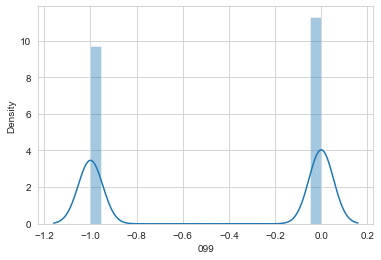

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

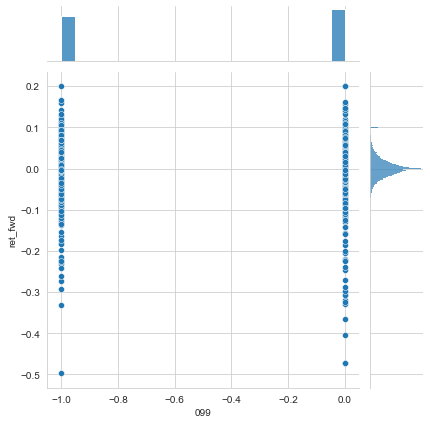

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
alphas.groupby(alphas[f'{alpha:03}']).ret_fwd.describe()

count      mean       std       min       25%  50%       75%       max
099                                                                          
-1   33512.0  0.000805  0.028056 -0.497644 -0.013747  0.0  0.013531  0.199969
 0   39038.0  0.000734  0.028506 -0.473149 -0.013725  0.0  0.013794  0.200000

## Alpha 100

```
-rank(ts_sum(returns, 10) / ts_sum(ts_sum(returns, 2), 3)) * 
        rank((returns * cap))
```

In [ ]:
def alpha100(r, cap):
    """(0 - (1 * (((1.5 * scale(indneutralize(
                indneutralize(rank(((((close - low) - (high -close)) / (high - low)) * volume)), 
                                IndClass.subindustry), IndClass.subindustry))) - 
    scale(indneutralize((ts_corr(close, rank(adv20), 5) - rank(ts_argmin(close, 30))), IndClass.subindustry))) * (volume / adv20))))
    """
    pass

## Alpha 101

```
-ts_max(rank(ts_corr(rank(volume), rank(vwap), 5)), 5)
```

In [ ]:
def alpha101(o, h, l, c):
    """((close - open) / ((high - low) + .001))"""
    return (c.sub(o).div(h.sub(l).add(1e-3))
            .stack('code')
            .swaplevel())

In [ ]:
alpha = 101

In [ ]:
%%time
alphas[f'{alpha:03}'] = alpha101(o, h, l, c)

CPU times: total: 46.9 ms
Wall time: 142 ms


In [ ]:
alphas[f'{alpha:03}'].to_hdf('cn_alphas.h5', f'alphas/{alpha:03}')

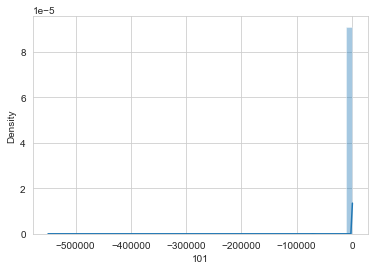

In [ ]:
sns.distplot(alphas[f'{alpha:03}']);

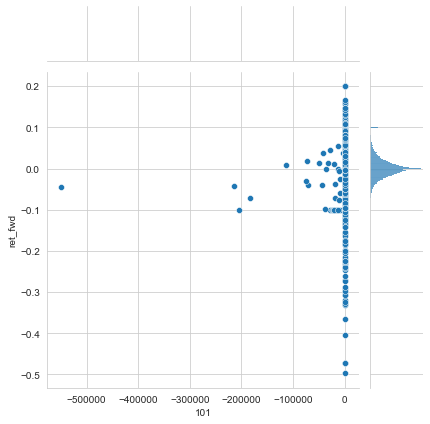

In [ ]:
g = sns.jointplot(x=f'{alpha:03}', y='ret_fwd', data=alphas);


In [ ]:
mi[alpha] = get_mutual_info_score(alphas.ret_fwd, alphas[f'{alpha:03}'])
mi[alpha]

0.04388838520116689

## 存储结果

In [ ]:
alphas = []
with pd.HDFStore('cn_alphas.h5') as store:
    keys = [k[1:] for k in store.keys()]
    for key in keys:
        i = int(key.split('/')[-1])
        alphas.append(store[key].to_frame(i))
alphas = pd.concat(alphas, axis=1)

In [ ]:
alphas.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 72550 entries, ('sh.600030', Timestamp('2017-07-04 00:00:00')) to ('sz.300274', Timestamp('2023-06-20 00:00:00'))
Data columns (total 79 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   1       71459 non-null  float64
 1   2       71366 non-null  float64
 2   3       50843 non-null  float64
 3   4       72150 non-null  float64
 4   5       71857 non-null  float64
 5   6       71804 non-null  float64
 6   7       71207 non-null  float64
 7   8       71800 non-null  float64
 8   9       71845 non-null  float64
 9   10      71845 non-null  float64
 10  11      71632 non-null  float64
 11  12      71845 non-null  float64
 12  13      71459 non-null  float64
 13  14      71804 non-null  float64
 14  15      13653 non-null  float64
 15  16      72350 non-null  float64
 16  17      70876 non-null  float64
 17  18      70858 non-null  float64
 18  19      60050 non-null  float64
 19  20      72093 non-nul

In [ ]:
alphas.to_hdf('cn_data.h5', 'factors/formulaic')